# Оглавление:

### 1. Первичная работа с данными
         - Загрузка данных, пакетов
         - Используемые функции
         - Проверка на всякие ошибки
         - Данные о днях и странах в новые переменные
         - В данных о транзакциях приведем переменную from_page в фиктивные переменные
         - Окончательные датасеты
  
### 2. Проверка сплит-системы 
         - Первый взгляд на описательную статистику
         - Проверка распределения в тестовой и контрольной группах.
         - Проверка распределения раздельно для тех, у кого есть данные о днях, и для тех, у кого таких данных нет

### 3. А/В тест
         - Для выручки и монет
         - Промежуточный вывод

### 4. Propensity Score Matching
         - Описание алгоритма
         - Logit propensity scores
         - Matching и выводы об А/В тесте

### 5. Регрессионный анализ влияния отдельных переменных
         - Первый взгляд на построенние адекватной модели
         - Проблемы с гетороскедастичностью и вопросы к спецификации модели
         
### 6. Фильтрация
         - Подозреваемые переменные и их распредление. Фильтрация и распределение после фильтрации
         - Проверка распределения всех характеристик после фильтрации
         - А/В после фильтрации
         - PSM после фильтрации (тот же алгоритм как и до фильтрации) и А/В

### 7. Регрессионный анализ влияния отдельных переменных после фильтрации
         - Длинная / короткая регресия
         - Гетероскедастичность и устойчивые к гетероскедастичности ошибки
         - Логирифмирование выручки и проверка Бокса-Кокса. Формирование окончательной модели.
### 8. Данные о транзакциях.
         - Какие именно транзакции в таблице. Таблица средних
         - Таблицы значимости разницы между различными каналами привлечения
         
### 9. Общие выводы

=================================================================================================================

### 1. Первичная работа с данными

### Загрузка данных, пакетов

Подгрузим нужные пакеты

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime as dt
import pycountry
import matplotlib.pyplot as plt
import pycountry_convert as pc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import cluster
import seaborn as sns
%matplotlib inline

Подгрузим наши данные

In [2]:
import requests
from urllib.parse import urlencode
import io

urls = ['ya_J0W53q_P-Pg', 'e8JOiJhNdc1fqA', 'E6MshHtdPdtMBQ', 'iTLiuxIWRc42Hg', 'JykTu7f00oCHpw', 'NsvacYvGbqo_dQ']
data_names = ['users_test',
              'users_control_1',
              'users_control_2',
              'transactions_test', 
              'transactions_control_1', 
              'transactions_control_2']

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
for i in range(len(urls)):
    public_key = 'https://disk.yandex.ru/d/' + urls[i]
    final_url = base_url + urlencode(dict(public_key = public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download = requests.get(download_url).content
    locals()[data_names[i]] = pd.read_csv(io.StringIO(download.decode('utf-8')), sep = ';')

### Используемые функции

In [3]:
def get_country_list(series_of_countries, top):
    '''Берет список стран и возвращает список стран, названия которых приведены в едином стандарте
    + заменяет непопулярные страны, что не входят в топ на the_other'''
    #преведем названия стран к нужному формату
    series_of_countries = list(map(lambda x: x.replace('United Kingdom (Great Britain)', 'United Kingdom'), 
                                   series_of_countries.to_list()))
    iso_countries_names = {keys: pycountry.countries.search_fuzzy(keys)[0].name 
                           for keys in np.unique(np.array(series_of_countries))}
    result1 = list(map(lambda x: iso_countries_names[x], series_of_countries))
    #добавим континент
    continents_names = {keys: country_to_continent(keys) 
                        for keys in list(iso_countries_names.values())}
    result2 = list(map(lambda x: continents_names[x], result1))
    #теперь теперь объединеним непопулярные странны
    temp = pd.Series(result1).value_counts()
    i = 0
    y = 0
    while y < sum(temp.values) * top:
        y = y + temp.values[i]
        i = i + 1
    popular_countries = temp.index[0:(i+1)]
    replaced_names = {keys: keys if keys in popular_countries else 'the_other' for keys in iso_countries_names.values()}
    result1 = list(map(lambda x: replaced_names[x], result1))
    return np.matrix([result1, result2])

In [4]:
def country_to_continent(country_name):
    '''Берет название страны, возвращает название континента'''
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [5]:
def get_dummies(columns_list, pandas_table):
    '''Берет пандас-таблицу и список столбцов. Добавляет в таблицу фиктивные переменные на каждое уникальное значение
    кроме самого популярного для каждого столбца из списка. Количесво добавленых столбцов и самое популярное уникальное
    значение выводит после каждого обработанного столца из списка.'''
    for i in columns_list:
        column = pandas_table[i]
        l = column.value_counts().index
        fe = l[0]
        l = l[1:]
        for j in range(len(l)):
            name_of_the_column = 'is_' + l[j].lower().replace(' ', '_')
            pandas_table[name_of_the_column] = list(map(lambda x: 1 if x == l[j] else 0, column))
        print(f'Столбец {i.upper()} был превращен в {len(l)} столбцов. \
        Без фиктивной переменной осталось самое частое значение: {fe}')
    return pandas_table     

In [6]:
def a_a_boot(
    pandas_table,
    rule0,
    rule1,
    boot_simulations = 1000,
    a_a_sample = 1000
):
    '''Проводит А/А тест для всех характеристик из датасета.\
    Береться пандас-таблица, правило определения одной группы, правило отделения второй группы.\
    Возвращается словарь с листом p-values для каждой симуляции.\
    Если уникальных значений больше 5, то используется тест Манна-Уитни или т-тест в зависимости от распределения.\
    Если уникальных значений меньше или равно 5, то Хи-квадрат'''
    list_of_variables = pandas_table.columns
    pv_dict = {key:0 for key in list_of_variables}
    for c in list_of_variables:
        
        v0 = pandas_table.query(rule0)[c] #should be a numpy array
        v1 = pandas_table.query(rule1)[c]
        #list with results
        res = []
        if pandas_table[c].value_counts().index.size > 5: # t-test or 
            for i in range(boot_simulations):
                
                b0 = np.random.choice(v0, a_a_sample, replace = False)
                b1 = np.random.choice(v1, a_a_sample, replace = False)
                #check whether is one of the samples are non-normal
                if ss.normaltest(b0).pvalue < 0.05 or ss.normaltest(b1).pvalue < 0.05:
                    res.append(ss.mannwhitneyu(b0, b1).pvalue)
                else:       
                    res.append(ss.ttest_ind(b0, b1).pvalue)
        else: #chisquared
            
            v = pandas_table[c].value_counts()
            v = {v.index[keys]: 0 for keys in range(v.index.size)}
            
            for i in range(boot_simulations):
                
                b0 = pd.Series(np.random.choice(v0, a_a_sample, replace = False)).value_counts()
                b0 = {b0.index[keys]: b0.values[keys]  for keys in range(b0.index.size)}
        
                b1 = pd.Series(np.random.choice(v1, a_a_sample, replace = False)).value_counts()
                b1 = {b1.index[keys]: b1.values[keys]  for keys in range(b1.index.size)}
                
                temp0 = v.copy()
                temp1 = v.copy()
                for g in b0.keys():
                    temp0[g] = b0[g]
                for g in b1.keys():
                    temp1[g] = b1[g]
                if 0 in temp1.values():
                    x = 0
                else:
                    x = ss.chisquare(f_obs = [*temp0.values()], f_exp = [temp1[j] for j in temp1.keys()]).pvalue
        
                res.append(x)
        pv_dict[c] = res
    return pd.DataFrame(pv_dict)

In [7]:
def FPR(pt_r):
    '''False positive rate'''
    lst_c = pt_r.columns
    N = pt_r.shape[0]
    rate = {}
    for i in lst_c:
        rate[i] = pt_r.loc[pt_r[i] < 0.05,].shape[0] / N
    return pd.Series(rate)

In [8]:
def evcl_dist(point0, point1, cluster_n, kmeans):
    '''Эвклидово расстояние'''
    return np.sqrt((point0 - kmeans.cluster_centers_[cluster_n][0])**2 + (point1-kmeans.cluster_centers_[cluster_n][1])**2)

In [9]:
def ATE(df, list_of_scores, treatment, random_state_, n_cluster):
    '''Делает Averege Treatment Effect на двух propencity score значениях.
    Кластаризирует с помощью k-means.'''
    #k-means clustering
    X = [[df.iloc[i, df.columns.to_list().index(list_of_scores[0])],
         df.iloc[i, df.columns.to_list().index(list_of_scores[1])]]  for i in range(df.shape[0])]
    kmeans = cluster.KMeans(n_clusters = n_cluster , random_state = random_state_).fit(X)
    df['groups'] = kmeans.labels_
    
    
    #find the distance
    df['dist'] = [evcl_dist(i0, i1, c, kmeans) for i0, i1, c in zip(df.loc[:,list_of_scores[0]].to_numpy(),
                                                            df.loc[:,list_of_scores[1]].to_numpy(),
                                                            df.loc[:,'groups'].to_numpy())]
    
    
    #find the list of prepaired groups
    list_of_groups = [i in df.query(f'{treatment} == 1').groups.unique() 
                  and i in df.query(f'{treatment} == 0').groups.unique()
                  for i in range(n_cluster)]
    list_of_groups = np.array([i for i in range(n_cluster)])[list_of_groups]
    
    
    #find the differences in groups between control and treatment
    df_temp = df.loc[:,[list_of_scores[0], list_of_scores[0], 'groups', 'dist', 'treatment']]
    
    X0 = df_temp.query(f'{treatment} == 0').groupby(['groups'], as_index = False).agg({'dist':'count'})
    X0 = X0.loc[[i in list_of_groups for i in X0.groups]]
    
    X1 = df_temp.query(f'{treatment} == 1').groupby(['groups'], as_index = False).agg({'dist':'count'})
    X1 = X1.loc[[i in list_of_groups for i in X1.groups]]
    
    addings_array = X0.dist.to_numpy() - X1.dist.to_numpy()
    
    
    #drop unoprepaired groups
    dim0 = df.shape[0]
    df = df.loc[[i in list_of_groups for i in df.groups]]
    dim1 = df.shape[0]
    print(f'Удалено {dim0-dim1} наблюдений при random state = {random_state_}')
    
    
    #find the ates    
    df_psm = df
    for n, i in zip(addings_array, list_of_groups):
        if n > 0: 
            indexes = df.query(f'{treatment} == 1 & groups == {i}').sort_values(by = 'dist').index.to_list()
            
            shp = abs(n) // len(indexes) + 1
            indexes = indexes*shp
            indexes = indexes[:abs(n)]
            
            df_psm = pd.concat([df_psm, df.loc[indexes, :]])
            
        elif n < 0:
            indexes = df.query(f'{treatment} == 0 & groups == {i}').sort_values(by = 'dist').index.to_list()
            
            shp = abs(n) // len(indexes) + 1
            indexes = indexes*shp
            indexes = indexes[:abs(n)]
            
            df_psm = pd.concat([df_psm, df.loc[indexes, :]])

    t = df_psm.query('treatment == 1').total_revenue.to_numpy()
    c = df_psm.query('treatment == 0').total_revenue.to_numpy()
    result = [t.mean(), c.mean(), t.mean() - c.mean(), round(ss.ttest_ind(t, c).pvalue, 5)]
    return result   

In [10]:
def Box_Cox_comparison(endo, exog): #pandas Series and DataFrame 
    '''Сравнение Бокса_Кокса, чтобы понять стоит ли логарифмировать зависиную переменную
    Берет ендогенную переменную и нужный набор экзагенных, возвращает нужно ли брать с логарифмом зависимую или нет.'''
    
    endo = endo.to_numpy()
    if endo.min() > 0:
        print('К зависимой переменной ничего не добавили')
    else:
        endo = endo + abs(endo.min()) + 1
        print(f'К зависимой переменной добавили ее минимальное значение ({endo.min() - 1}) по модулю + 1')
        
    deg = exog.shape[0]
    box_adj = np.prod(endo ** (1/deg))
    endo = endo / box_adj
    
    model1 = sm.OLS(endo, exog)
    results1 = model1.fit()
    
    endo = np.log(endo)
    model2 = sm.OLS(endo, exog)
    results2 = model2.fit()
    
    s1 = np.sum(results1.resid ** 2)/(deg-exog.shape[1])
    s2 = np.sum(results2.resid ** 2)/(deg-exog.shape[1])
    if s1 < s2:
        result = f'Без логарифма лучше, так как SEE меньше: SEE = {s1}, а с логарифмом SEE = {s2}'
    else:
        result = f'С логарифмом лучше, так как SEE меньше: SEE = {s2}, а без логарифма SEE = {s1}'
    
    return print(result)

### Проверка на всякие ошибки

Посмотрим, есть ли повторяющиеся клиенты в контрольных группах и в тестовой. Если повторов нет, то можно просто объединить таблички и не множить сущности.

In [11]:
temp_v1 = sum([x in users_control_2.uid.unique() for x in users_control_1.uid.unique()])
temp_v2 = sum([x in users_test.uid.unique() for x in users_control_1.uid.unique()])
temp_v3 = sum([x in users_test.uid.unique() for x in users_control_2.uid.unique()])
f'В контрольной группе 1 и 2 {temp_v1} повторяющихся пользователей, аналогично {temp_v2} и \
{temp_v3} пересечений между тестовой и контрольными группами 1 и 2'

'В контрольной группе 1 и 2 0 повторяющихся пользователей, аналогично 0 и 0 пересечений между тестовой и контрольными группами 1 и 2'

In [12]:
users = pd.concat([users_test, users_control_1, users_control_2]).reset_index(drop = True)

In [13]:
uid_test = users_test.uid.to_list()
uid_control_1 = users_control_1.uid.to_list()
uid_control_2 = users_control_2.uid.to_list()

In [14]:
users['control_1'] = [1 if x in uid_control_1 else 0 for x in users.uid.to_list()]
users['control_2'] = [1 if x in uid_control_2 else 0 for x in users.uid.to_list()]

### Данные о днях и странах в новые переменные 

Теперь посмотрим, что у нас есть в списке стран. Странновое различие не такое большое, большинство клиентов находятся в не самом длинном списке стран. Так как хочется перевести переменную "страна" в фиктивные переменные, сократим список стран так, чтобы для 95% пользователей учитывалась страна. Для остальных мы запишем страну как "другую". Чтобы дополнительно учитывать некоторые культурные особенности добавим переменную континент.

In [15]:
m = get_country_list(users.country, 0.95)
users['country'] = m[0].tolist()[0]
users['continent'] = m[1].tolist()[0]

Теперь разбиремся с данными о днях. Посмотрим, существует ли "нулевой" день. Если не существует, то заменим нулями все пропуски.

In [16]:
try:
    users.visit_days.value_counts().index.to_list().index('0')
except ValueError:
    print('Здесь нет нулей, только пустые значения \nЗаполним пустые значение нулями \nВот новая таблица с значениями')
    users.visit_days = users.visit_days.fillna('0')
    print(users.visit_days.value_counts())
except:
    print('что-то не то другое')      

Здесь нет нулей, только пустые значения 
Заполним пустые значение нулями 
Вот новая таблица с значениями
0                                                                  4018
1                                                                  1704
1,2                                                                 767
1,2,3                                                               436
1,2,3,4                                                             340
                                                                   ... 
1,2,3,5,6,7,8,10,11,12,13,14,15                                       1
2,3,4,5,6,7,8,9,10,11,13,14,15,16,18,19,20                            1
1,2,3,4,5,8,9,10,13,14,15                                             1
1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,18,19,20,21,22,23,25,27,28       1
2,3,5,7,9,10,12,14,15                                                 1
Name: visit_days, Length: 2133, dtype: int64


Теперь приведем данные о днях в три переменные: самый дальний день авторизации в приложении после регистрации, количество активных недель (считается неделя активной, если заходил больше в половине дней в неделе) и количество дней, когда пользователь заходил в приложение. В целом, этого должно быть достаточно, что передать большую часть информации заложенную в списке дней.

In [17]:
users['visit_days_max'] = list(map(lambda x: int(x.split(',')[-1]) if len(x) > 1 else int(x), users.visit_days.to_list()))
users['active_weeks'] = list(map(lambda x: np.sum([pd.Series([y // 7 for y in [int(x) for x in x.split(',')]]) \
                                                   .value_counts().values > 4]),
                                                    users.visit_days))
users['n_visit_days'] = list(map(lambda x:  np.count_nonzero([int(x) for x in x.split(',')]), users.visit_days))

Заполним остальные пропуски.

In [18]:
users.coins = users.coins.fillna(0)
users.was_premium = users.was_premium.fillna(0).astype(int)
users.is_premium = users.is_premium.fillna(0).astype(int)

In [19]:
f'Вот такое количество пропусков осталось: {users.isna().sum().sum()}'

'Вот такое количество пропусков осталось: 0'

Преведем страны и континенты в фиктивные переменные.

In [20]:
df = get_dummies(['continent', 'country'], users)

Столбец CONTINENT был превращен в 5 столбцов.         Без фиктивной переменной осталось самое частое значение: North America
Столбец COUNTRY был превращен в 14 столбцов.         Без фиктивной переменной осталось самое частое значение: United States


### В данных о транзакциях приведем переменную from_page в фиктивные переменные

Данные о транзакциях приведем в такое же состояние: удалим пустые значения, положим в одну таблицу, добавим фиктивные переменные относятся ли данное наблюдение к контрольной группе.

In [21]:
transactions_control_2 = transactions_control_2.dropna(how = 'all')
transactions_control_1 = transactions_control_1.dropna(how = 'any') # почему-то только так работает, а не как должно. Лишнего не удалено тем не менее

In [22]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2]).reset_index(drop = True)
uid_test_t = transactions_test.uid.to_list()
uid_control_1_t = transactions_control_1.uid.to_list()
uid_control_2_t = transactions_control_2.uid.to_list()
transactions['control_1'] = [1 if x in uid_control_1_t else 0 for x in transactions.uid.to_list()]
transactions['control_2'] = [1 if x in uid_control_2_t else 0 for x in transactions.uid.to_list()]

Теперь посмотрим на время: по не совсем понятной причине время регистрации после времени транзакции. Возможно, просто перепутанны. Не думаю, что время оплаты и регистрации имеют значение без друг друга: куда интереснее смотреть на разницу между ними. То есть сколько времени прошло, пока те, кто таки купили премиум, пользовались бесплатной версией.

In [23]:
transactions['difference_reg_paid'] = pd.to_datetime(transactions.paid_at) - pd.to_datetime(transactions.joined_at)
transactions['difference_reg_paid'] = [x.days for x in transactions['difference_reg_paid'].to_list()]

Поскольку наблюдейний не много, давайте сократим количество количество версий from_page, оставим самые популярные: те, что описывают 90% всех случаев.

In [24]:
temp = transactions.from_page.value_counts()
i = 0
y = 0
while y < sum(temp.values) * 0.9:
    y = y + temp.values[i]
    i = i + 1
from_page_list = temp.index[0:(i+1)]
replaced_names = {keys: keys if keys in from_page_list else 'the_other_page' for keys in temp.index}
transactions.from_page = list(map(lambda x: replaced_names[x], transactions.from_page))

В новую таблицу положим данные уже с фиктивными переменными.

In [25]:
df_t = get_dummies(['from_page', 'product_type'], transactions)

Столбец FROM_PAGE был превращен в 12 столбцов.         Без фиктивной переменной осталось самое частое значение: empty_likes
Столбец PRODUCT_TYPE был превращен в 3 столбцов.         Без фиктивной переменной осталось самое частое значение: coins


### Окончательные датасеты

In [26]:
df_t = pd.merge(df_t, df, on = 'uid')

Уберем из таблицы все нечисловые значения.

In [27]:
df = df.drop(['uid', 'country', 'visit_days', 'continent'], axis=1)

Создадим копию, на случай если понадобится 

In [28]:
df_reserve = df

Заменим ограничения по фильтру на относительные возраста. Также добавим переменную treatment

In [29]:
df['age_filter_start'] = df.age_filter_start - df.age
df['age_filter_end'] = df.age_filter_end - df.age
df['treatment'] = [0 if x == 1 else 1 for x in (df.control_1 + df.control_2).to_list()]

Уберем ненужные все нечисловые значения и из таблицы о транзакциях.

In [30]:
df_t = df_t.drop(['uid', 'country_x', 'visit_days',
                  'joined_at', 'paid_at', 'payment_id',
                  'control_1_x', 'control_2_x'], axis = 1)
df_t['treatment'] = [0 if x == 1 else 1 for x in (df_t.control_1_y + df_t.control_2_y).to_list()]
df_t = df_t.drop(['control_1_y', 'control_2_y'], axis = 1)

После того, как данные причесанны можно посмотреть, а насколько хорошо работает разделение. 
Посмотрим описательную статистику.

### 2. Проверка сплит-системы

Посмотрим как распределены в тестовой и контрольных группах строго независищие от повышения выручки переменные (страновые переменные, возраст, пол (ну я на это надеюсь)), и переменные, которые в теории могут зависеть от повышения выручки (все остальные).

In [31]:
df.loc[:, ['age', 'attraction_coeff', 'coins', 'gender', 'age_filter_start',
       'age_filter_end', 'views_count', 'was_premium', 'is_premium',
       'total_revenue', 'treatment']] \
        .query('treatment == 1').describe().drop(columns = ['treatment'])

,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,31.889276,316.411328,2.614206,0.953110,-5.187790,6.359564,50.391133,0.094708,0.036444,534.080316
std,10.245287,323.373725,129.608910,0.211427,7.097109,13.310355,318.676437,0.292845,0.187414,4371.682632
min,16.000000,0.000000,0.000000,0.000000,-83.000000,-76.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,1.000000,-3.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,30.000000,250.000000,0.000000,1.000000,-3.000000,3.000000,6.000000,0.000000,0.000000,0.000000
75%,38.000000,520.250000,0.000000,1.000000,-3.000000,3.000000,22.000000,0.000000,0.000000,0.000000
max,99.000000,1000.000000,8466.000000,1.000000,76.000000,83.000000,12831.000000,1.000000,1.000000,129870.000000


In [32]:
df.loc[:, ['age', 'attraction_coeff', 'coins', 'gender', 'age_filter_start',
       'age_filter_end', 'views_count', 'was_premium', 'is_premium',
       'total_revenue', 'treatment']] \
        .query('treatment == 0').describe().drop(columns = ['treatment'])

,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000
mean,32.071013,314.976987,12.303696,0.956183,-5.197699,6.657485,44.763366,0.098443,0.044514,523.210716
std,10.214004,323.564081,1078.326321,0.204699,6.971428,13.432408,267.064643,0.297929,0.206246,6019.787854
min,16.000000,0.000000,0.000000,0.000000,-83.000000,-70.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,1.000000,-3.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,30.000000,243.000000,0.000000,1.000000,-3.000000,3.000000,6.000000,0.000000,0.000000,0.000000
75%,38.000000,533.000000,0.000000,1.000000,-3.000000,3.000000,20.000000,0.000000,0.000000,0.000000
max,99.000000,1000.000000,99958.000000,1.000000,67.000000,83.000000,16157.000000,1.000000,1.000000,486330.000000


Значимых различий сходу не в страновых переменных не видно между контрольной и тестовой группой. Проверим распределние кусочкам с помощью симуляций.

###  Проверка распределения в тестовой и контрольных группах

In [33]:
np.random.seed(1)
compare_table = a_a_boot(df.drop(['total_revenue', 'control_1', 'control_2'], axis = 1), 
                                      'treatment == 1', 'treatment == 0')

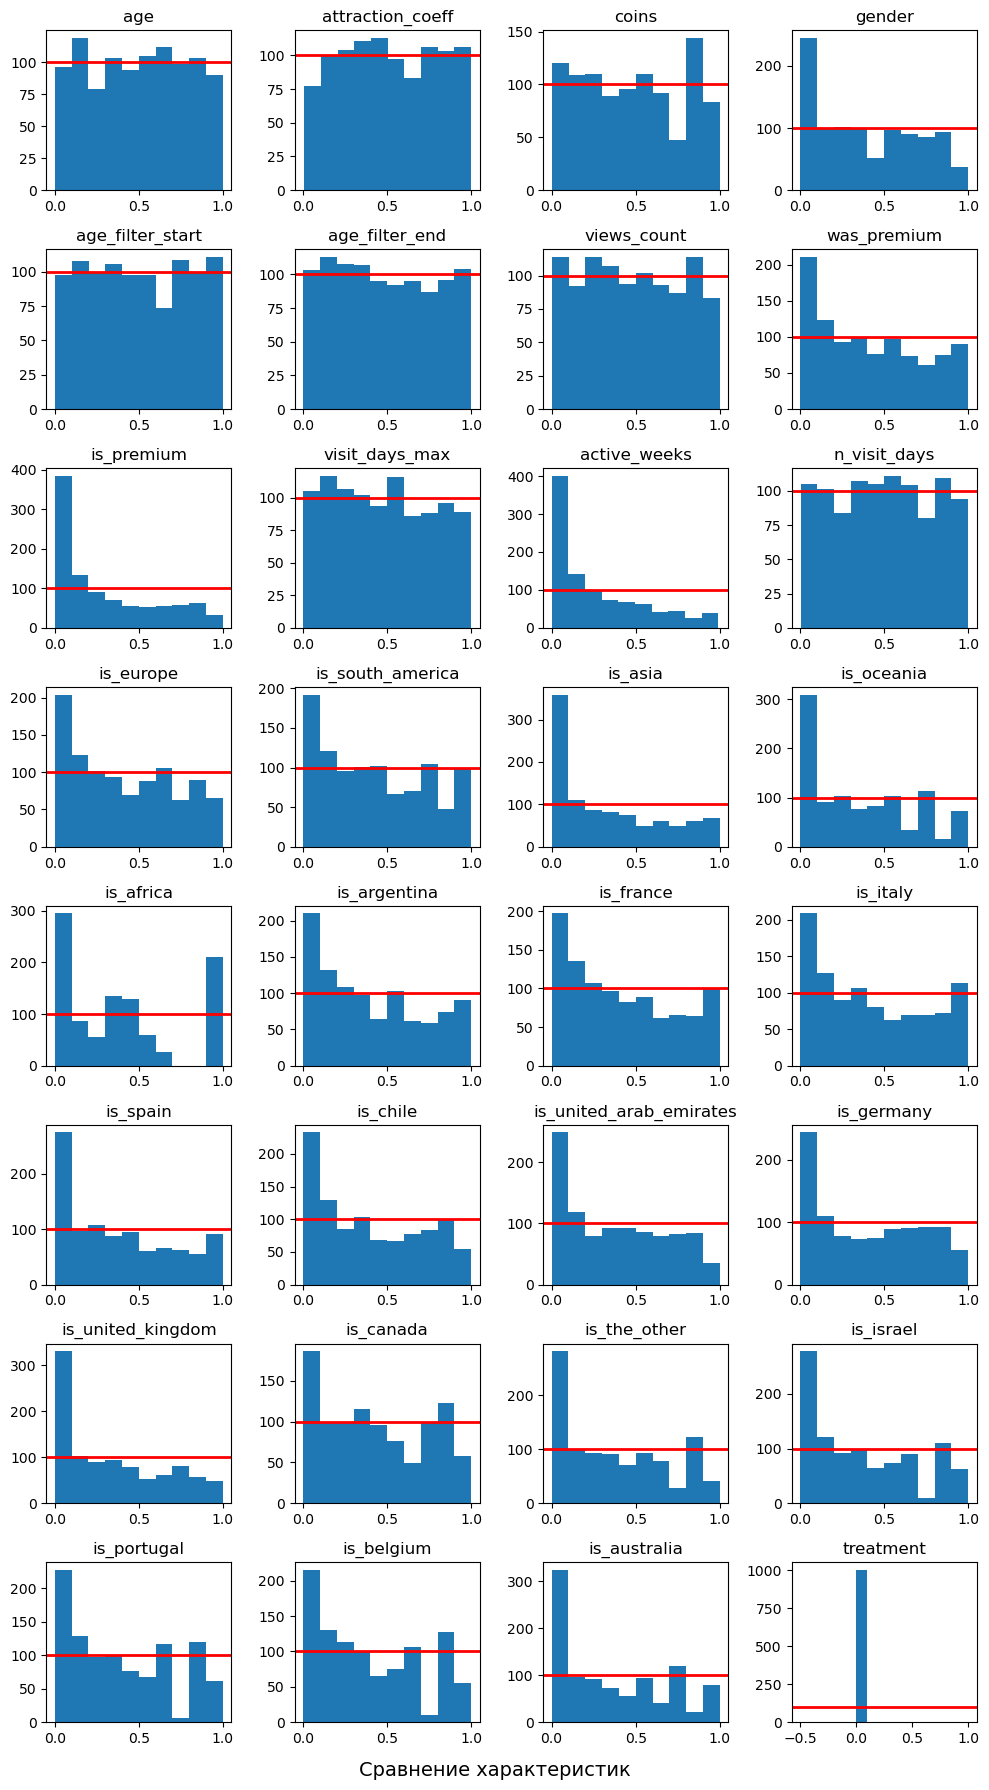

In [34]:
keys = []
for i in range(8):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(8, 4, figsize=(10, 18))
  
for i in range(8):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(compare_table[compare_table.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(compare_table.columns[x])

figure.suptitle('Сравнение характеристик', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

In [35]:
FPR(compare_table).sort_values(ascending = False)

treatment                  1.000
active_weeks               0.305
is_premium                 0.278
is_africa                  0.275
is_asia                    0.263
is_united_kingdom          0.243
is_oceania                 0.240
is_australia               0.231
is_the_other               0.207
is_israel                  0.190
is_spain                   0.183
is_united_arab_emirates    0.172
gender                     0.170
is_germany                 0.165
is_chile                   0.149
is_belgium                 0.140
was_premium                0.139
is_europe                  0.135
is_italy                   0.133
is_argentina               0.130
is_portugal                0.130
is_france                  0.126
is_canada                  0.119
is_south_america           0.118
coins                      0.059
age                        0.058
views_count                0.058
age_filter_end             0.055
visit_days_max             0.055
n_visit_days               0.053
age_filter

Формально, только количество просмотров, привлекательность и нижняя граница фильтра проходят по криттерию что FPR должен быть менее 0.05. Чуть хуже, но не сильно обстоят дела с возрастом, количество дней, верхней границей фильтра, продолжительность пользования и количество внутренней валюты.

Все страновые переменные смещены значительно, причем это касается и агрегированных переменных (континет), значит смещение не только связано с малым количеством данных. Также сильно смещены и переменные подписки (премиум и был премиумом) и пол.

### Проверка распределения раздельно для тех, у кого есть данные о днях, и для тех, у кого таких данных нет

Смысл не столько в том, что отсутсвующие данные о днях влияют на смещение, нет. А в том, что это могут быть данные с ошибками, которые я при первом взляде не увидел. 

In [36]:
df.query('n_visit_days == 0').describe()

,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,...,is_united_arab_emirates,is_germany,is_united_kingdom,is_canada,is_the_other,is_israel,is_portugal,is_belgium,is_australia,treatment
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,...,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,31.229467,264.603285,0.069686,0.949726,-4.513191,6.220757,15.281483,0.055251,0.016924,127.829019,...,0.049776,0.039323,0.033350,0.028123,0.012444,0.017173,0.020657,0.020906,0.014684,0.331010
std,9.972859,338.312741,3.094579,0.218537,5.781728,12.548231,91.478407,0.228499,0.129002,1208.836749,...,0.217509,0.194387,0.179571,0.165346,0.110870,0.129931,0.142251,0.143087,0.120299,0.470635
min,16.000000,0.000000,0.000000,0.000000,-77.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,1.000000,-3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,62.000000,0.000000,1.000000,-3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,500.000000,0.000000,1.000000,-3.000000,3.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,99.000000,1000.000000,190.000000,1.000000,42.000000,83.000000,4770.000000,1.000000,1.000000,18304.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
df_visit_days_0 = df.query('n_visit_days == 0').drop(['active_weeks', 'visit_days_max', 'n_visit_days'], axis = 1)
df_visit_days_1 = df.query('n_visit_days != 0')

In [38]:
np.random.seed(2)
compare_table = a_a_boot(df_visit_days_0.drop(['total_revenue', 'control_1', 'control_2'], axis = 1), 
                                      'treatment == 1', 'treatment == 0') \
                                        .drop(['treatment'], axis = 1)

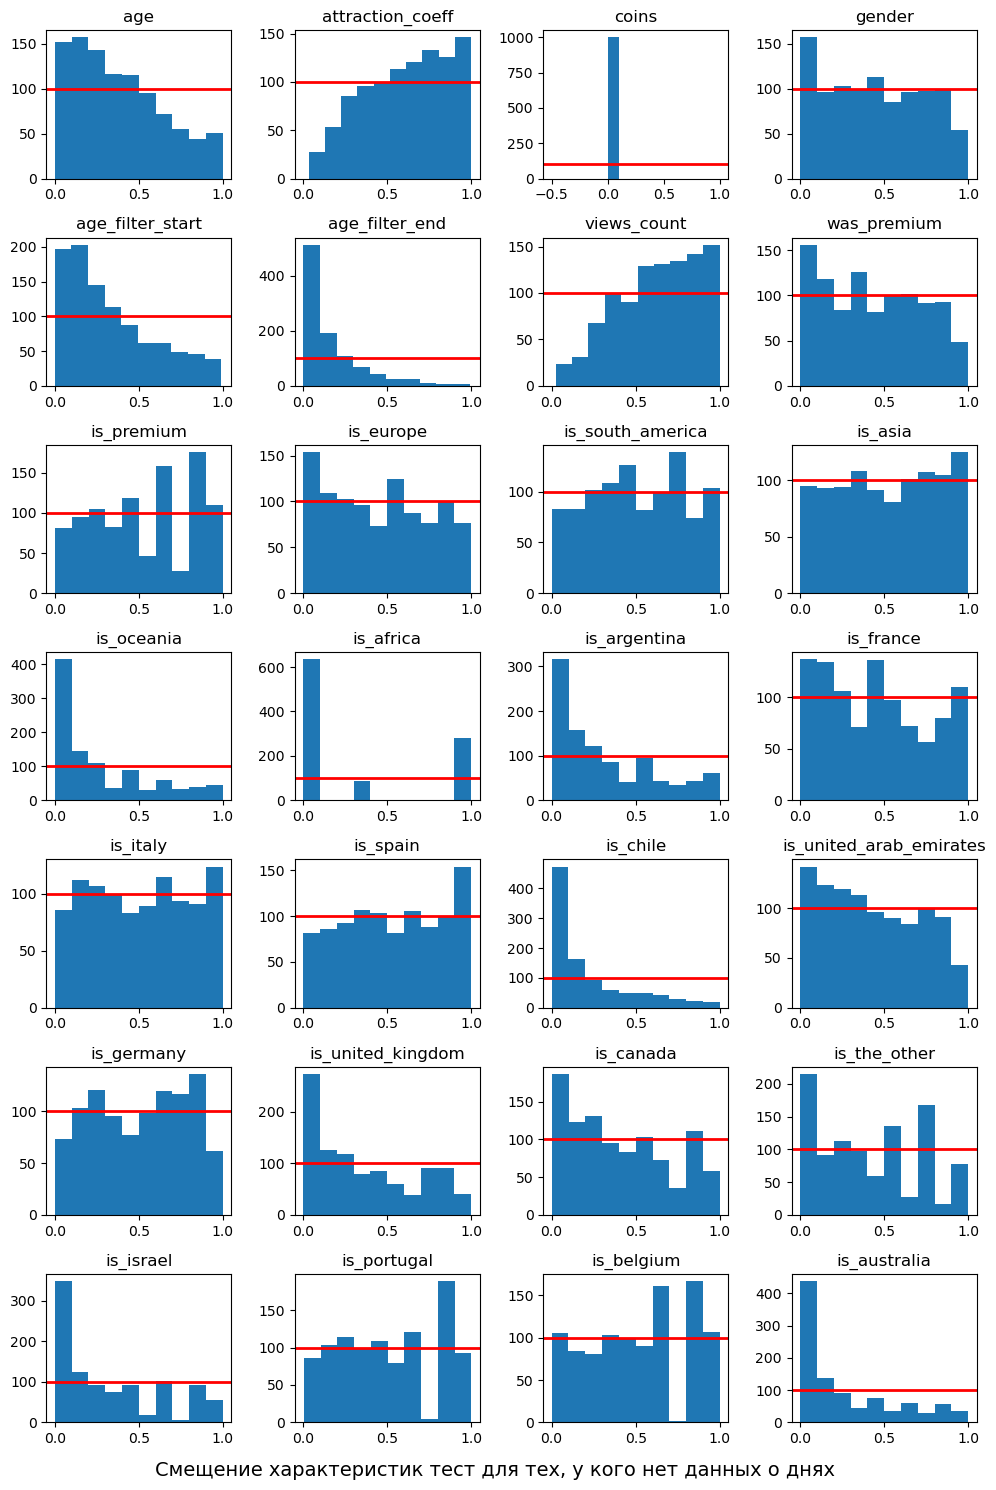

In [39]:
keys = []
for i in range(7):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(7, 4, figsize=(10, 15))
  
for i in range(7):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(compare_table[compare_table.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(compare_table.columns[x])

figure.suptitle('Смещение характеристик тест для тех, у кого нет данных о днях', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

In [40]:
FPR(compare_table).sort_values(ascending = False)

coins                      1.000
is_africa                  0.635
is_chile                   0.342
is_australia               0.335
age_filter_end             0.323
is_oceania                 0.291
is_israel                  0.255
is_united_kingdom          0.189
is_argentina               0.182
is_the_other               0.159
was_premium                0.104
gender                     0.101
age_filter_start           0.098
is_canada                  0.095
is_europe                  0.082
is_france                  0.077
is_united_arab_emirates    0.076
is_belgium                 0.060
age                        0.058
is_asia                    0.056
is_south_america           0.047
is_premium                 0.047
is_spain                   0.041
is_italy                   0.037
is_portugal                0.032
is_germany                 0.026
attraction_coeff           0.003
views_count                0.003
dtype: float64

Стало лучше, но несильно: часть страновых переменных стали распределены лучше, премиальная подписка распределена теперь  одинаково в тестовой и контрольной группе. Все так же не правильно распрделено was_premium и большинство страновых переменных, а так же распределение по полу.

In [41]:
np.random.seed(3)
compare_table = a_a_boot(df_visit_days_1.drop(['total_revenue', 'control_1', 'control_2'], axis = 1), 
                                      'treatment == 1', 'treatment == 0') \
                                        .drop(['treatment'], axis = 1)

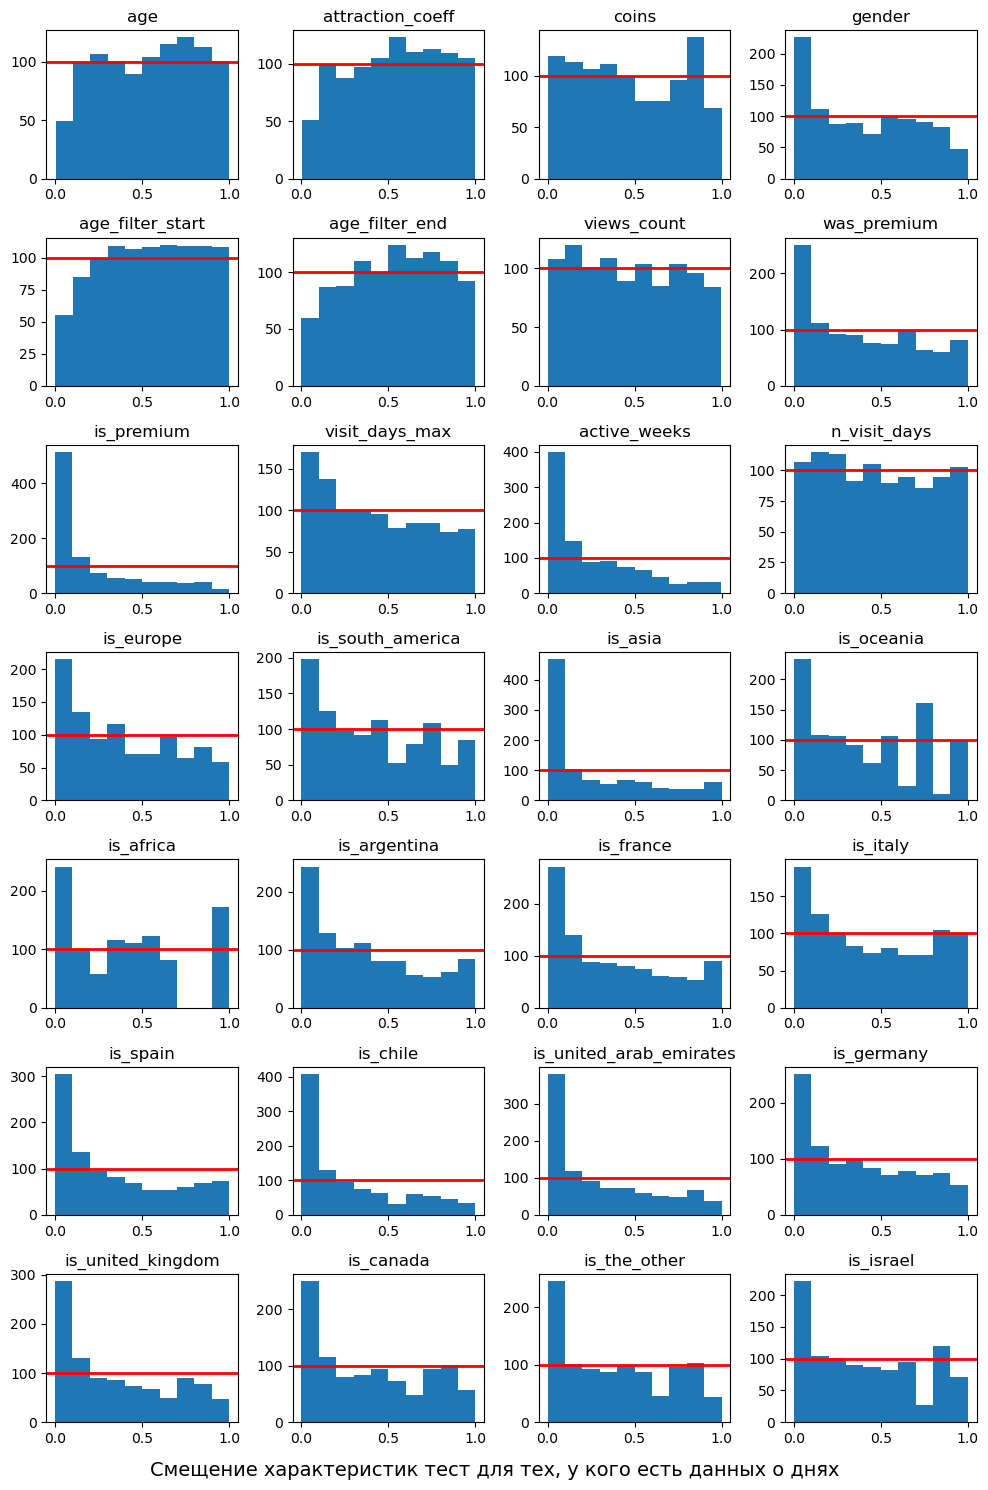

In [42]:
keys = []
for i in range(7):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(7, 4, figsize=(10, 15))
  
for i in range(7):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(compare_table[compare_table.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(compare_table.columns[x])

figure.suptitle('Смещение характеристик тест для тех, у кого есть данных о днях', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

In [43]:
FPR(compare_table).sort_values(ascending = False)

is_premium                 0.380
is_asia                    0.375
is_united_arab_emirates    0.311
active_weeks               0.311
is_chile                   0.298
is_africa                  0.215
is_spain                   0.211
is_united_kingdom          0.203
is_france                  0.187
is_canada                  0.184
is_germany                 0.184
is_australia               0.174
is_oceania                 0.170
was_premium                0.170
is_the_other               0.168
is_argentina               0.159
gender                     0.158
is_belgium                 0.144
is_israel                  0.140
is_europe                  0.137
is_italy                   0.129
is_south_america           0.124
is_portugal                0.104
visit_days_max             0.096
coins                      0.060
views_count                0.055
n_visit_days               0.054
age_filter_end             0.032
age                        0.018
attraction_coeff           0.016
age_filter

Нет значимого улучшения среди характеристик.

Отдельные тесты для отдельных датастов с данными о днях не показали ничего нового в плане распределениях характеристик: они все так же смещены. Значит нет смысла делить по наличию данным о днях. Это конечно странно что их нет и даже немного обидно, но исключение этих данных пока нецелесообразно. 

Зафиксировав тот факт, что данные смещенны по большинству можно не хотя провести все таки А/В тест.

### 3. А/В тест

### Для выручки и монет

In [44]:
t = df.query('treatment == 1').total_revenue.to_numpy()
c = df.query('treatment == 0').total_revenue.to_numpy()
if ss.normaltest(t).pvalue > 0.05 or ss.normaltest(c).pvalue > 0.05:
    p_value = ss.mannwhitneyu(t, c).pvalue
else:
    p_value = ss.ttest_ind(t, c).pvalue
print(f'Средняя выручка в тестовой группе {round(np.mean(t))} со стандартным отклонением {round(np.std(t))},' + 
      f'{chr(10)}в контрольной группе {round(np.mean(c))} со стандартным отклонением {round(np.std(c))},'+ 
      f' {chr(10)}вероятность равенства средних {round(p_value)}')

Средняя выручка в тестовой группе 534 со стандартным отклонением 4371,
в контрольной группе 523 со стандартным отклонением 6019, 
вероятность равенства средних 1


In [45]:
t = df.query('treatment == 1').coins.to_numpy()
c = df.query('treatment == 0').coins.to_numpy()
if ss.normaltest(t).pvalue > 0.05 or ss.normaltest(c).pvalue > 0.05:
    p_value = ss.mannwhitneyu(t, c).pvalue
else:
    p_value = ss.ttest_ind(t, c).pvalue
print(f'Среднее число монет в тестовой группе {round(np.mean(t))} со стандартным отклонением {round(np.std(t))},' + 
      f'{chr(10)}в контрольной группе {round(np.mean(c))} со стандартным отклонением {round(np.std(c))},'+ 
      f' {chr(10)}вероятность равенства средних {round(p_value)}')


Среднее число монет в тестовой группе 3 со стандартным отклонением 130,
в контрольной группе 12 со стандартным отклонением 1078, 
вероятность равенства средних 1


### Промежуточный вывод

А/B тест говорит, что нет значимого эффекта от увеличения выручки, а эффект на внутренню валюту пусть и незначимый тоже, даже отрицательный. Остановившись здесь можно сказать, что эффекта от увеличения стоимости подписки нет. Зная, что вообще-то у нас не все гладко с в спилит-системе, можно попробовать попробовать это несколько исправить.

### 4. Propensity Score Matching

Поскольку я не нашел никаких ошибок в данных таких, что их можно было удалить, и даже без тех данных, что казались подозрительным (0 активных дней) проблема смещенности не исчезла, проблема не в ошибках, а в сплит-системе. В целом, чтобы исправить можно попробовать исправить сплит-систему с помощью простого дедовского Propensity Score Matching

### Описание алгоритма

Здесь будет описание деталей мною использованного алгоритма. В остальном это обычный psm.
1. Оценку отнесения переменных к контрольной группе я оценил с помощью двух логит-регрессий на переменную treatment. Первая регрессия включала себя все переменные кроме выручки и странновых переменных, вторая только страновые переменные. Первое соображение что таким образом влияние странновых переменных получается больше, чем если из них не получать отдельный propensity score. Мне показалось это разумным, так как странновые характеристики были самые смешенные в сплит-системе. Второе соображение, что 2d достаточно просто визуально увидеть кластеры.
2. Кластеризацию я проводил с помощью k-means алгоритма, так как все координаты числовые, и он будет хорошо работать. Я понимаю, что это далеко не единственный вариант, но я не вижу, чем он здесь __радикально__ плох.
3. Так как K-means сильно зависят от начальной точки, я, чтобы получить более достоверную оценку, использовал 1000 разных стартовых точек (как выяснилось, не зря).
4. Количество кластеров непринципиально, пробовал разное количество остановился на 20. Такое количество не увеличивало исключение кластеров в которые не попадали либо данные из контрольной группы или из тестовой. (Почему данные исключались ниже)
5. Выбирая между "убирать точки из кластеров, если контрольных и тестовых наблюдений неравное количество" и "добавлять точки до равного количества в контрольной и тестовой группах", я выбрал второе. Добавление точек в кластер смещает его центр и, вообще говоря, меняеет его. Но пересчитывать по несколько раз после добавления -- это несколько too much, особенно если учесть, что алгоритм неустойчивый к начальным центрам кластеров. Соответственно если в кластере нет наблюдений из одной из групп, так кой кластер к сожалению, удалялся из выборки. Количество удаленных наблюденений для каждого старта печатается (вышло так, что постоянно пропадало одно наблюдение, ну ладно, на выборке 12912 нестрашно.
2. Подбирались недостающие для равного количества наблюдения по принципу наименьшего растояния до центра кластера: наблюдения ранжировались, а потом добавлялись. Непосредственно алгоритм можно посмотреть в *#find the ates*, переменная indexes.
6. По-хорошему нужно было для каждой кластеризации смотреть как исправилось смещение и проводить А/А тесты, но...
7. Для упрощения расчетов, чтобы не считать веса для ATE, а потом считать АТЕ, просто новые нужные наблюдения добавлялись в таблицу, а потом проводился просто А/В тест. Это эквивалентно расчету АТЕ, плюс получаем сразу значимость разницы средних между контрольно и тестовой группой, что позволяет прямо сравнить их с ппроведенным ранее А/В тестом.
8. На предыдущем шаге я посчитал разницу в средних для внутренней валюты. Я не могу придумать, не зная контекста, как можно однозначно интерпретировать эту разницу в любую сторону на самом деле, потому переменная coins отправлена в первую регрессию и на по ней не проводилось сравнение средних в PSM.

### Logit propensity scores

Разделим выборку по качественным и странновым переменным, не добавим в качественные выручку, так как это интересующая нас переменная

In [46]:
not_uniform = ['age', 'attraction_coeff', 'coins', 'gender', 'age_filter_start',
               'age_filter_end', 'views_count', 'was_premium', 'is_premium',
               'visit_days_max', 'active_weeks', 'n_visit_days']
not_uniform_c = ['is_europe', 'is_south_america', 'is_asia', 'is_oceania', 'is_africa',
               'is_argentina', 'is_france', 'is_italy', 'is_spain', 'is_chile',
               'is_united_arab_emirates', 'is_germany', 'is_united_kingdom',
               'is_canada', 'is_the_other', 'is_israel', 'is_portugal', 'is_belgium',
               'is_australia']

Найдем вероятностные значения относения в тестовую группу. Так как меня не интересуют коеффициенты при переменных, можно не исправлять ни мультиколлениарность, ни гетероскедастичность.

In [47]:
X_not_uniform = df[not_uniform].to_numpy()
y = df.treatment.to_numpy()
model = LogisticRegression(class_weight='balanced', max_iter = 1000)
model = model.fit(X_not_uniform, y)

Запишим в таблицу значение для качественных переменных

In [48]:
df['propensity_score'] = 1/(1+np.exp(-X_not_uniform.dot(model.coef_[0])))

Тоже самое со странновыми переменными

In [49]:
X_not_uniform_c = df[not_uniform_c].to_numpy()
model = LogisticRegression(class_weight='balanced')
model = model.fit(X_not_uniform_c, y)
df['propensity_score_c'] = 1/(1+np.exp(-X_not_uniform_c.dot(model.coef_[0])))

Вот такой график распределения propensity score.

<AxesSubplot:xlabel='propensity_score_c', ylabel='propensity_score'>

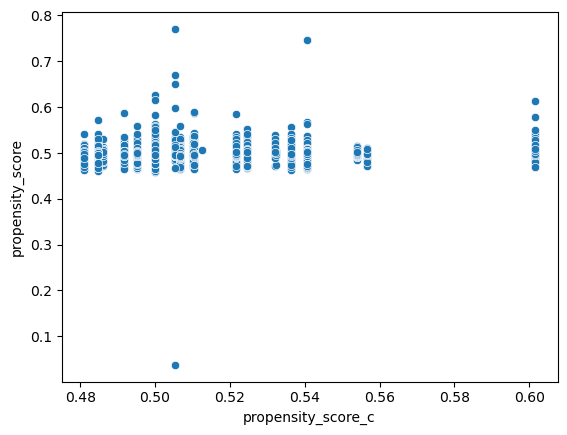

In [50]:
sns.scatterplot(data = df, x = 'propensity_score_c', y = 'propensity_score')

### Matching и выводы об А/В тесте

К-средние сильно зависят от старта, поэтому запустим 1000 разных стартов. Групп будет 20 (чем больше тем в целом лучше, но может, но при большом их числе могут попадаться кластеры без тестовых или контрольных наблюдений, которые не подходят для анализа).

In [51]:
ATEs = []
for i in range(1000):
    try:
        ATEs.append(ATE(df, ['propensity_score_c', 'propensity_score'], 'treatment', i, 20))
    except:
        print(f'с {i} что-то пошло не так')
        break

Удалено 1 наблюдений при random state = 0
Удалено 1 наблюдений при random state = 1
Удалено 1 наблюдений при random state = 2
Удалено 1 наблюдений при random state = 3
Удалено 1 наблюдений при random state = 4
Удалено 1 наблюдений при random state = 5
Удалено 1 наблюдений при random state = 6
Удалено 1 наблюдений при random state = 7
Удалено 1 наблюдений при random state = 8
Удалено 1 наблюдений при random state = 9
Удалено 1 наблюдений при random state = 10
Удалено 1 наблюдений при random state = 11
Удалено 1 наблюдений при random state = 12
Удалено 1 наблюдений при random state = 13
Удалено 1 наблюдений при random state = 14
Удалено 1 наблюдений при random state = 15
Удалено 1 наблюдений при random state = 16
Удалено 1 наблюдений при random state = 17
Удалено 1 наблюдений при random state = 18
Удалено 1 наблюдений при random state = 19
Удалено 1 наблюдений при random state = 20
Удалено 1 наблюдений при random state = 21
Удалено 1 наблюдений при random state = 22
Удалено 1 наблюдений 

Удалено 1 наблюдений при random state = 189
Удалено 1 наблюдений при random state = 190
Удалено 1 наблюдений при random state = 191
Удалено 1 наблюдений при random state = 192
Удалено 1 наблюдений при random state = 193
Удалено 1 наблюдений при random state = 194
Удалено 1 наблюдений при random state = 195
Удалено 1 наблюдений при random state = 196
Удалено 1 наблюдений при random state = 197
Удалено 1 наблюдений при random state = 198
Удалено 1 наблюдений при random state = 199
Удалено 1 наблюдений при random state = 200
Удалено 1 наблюдений при random state = 201
Удалено 1 наблюдений при random state = 202
Удалено 1 наблюдений при random state = 203
Удалено 1 наблюдений при random state = 204
Удалено 1 наблюдений при random state = 205
Удалено 1 наблюдений при random state = 206
Удалено 1 наблюдений при random state = 207
Удалено 1 наблюдений при random state = 208
Удалено 1 наблюдений при random state = 209
Удалено 1 наблюдений при random state = 210
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 376
Удалено 1 наблюдений при random state = 377
Удалено 1 наблюдений при random state = 378
Удалено 1 наблюдений при random state = 379
Удалено 1 наблюдений при random state = 380
Удалено 1 наблюдений при random state = 381
Удалено 1 наблюдений при random state = 382
Удалено 1 наблюдений при random state = 383
Удалено 1 наблюдений при random state = 384
Удалено 1 наблюдений при random state = 385
Удалено 1 наблюдений при random state = 386
Удалено 1 наблюдений при random state = 387
Удалено 1 наблюдений при random state = 388
Удалено 1 наблюдений при random state = 389
Удалено 1 наблюдений при random state = 390
Удалено 1 наблюдений при random state = 391
Удалено 1 наблюдений при random state = 392
Удалено 1 наблюдений при random state = 393
Удалено 1 наблюдений при random state = 394
Удалено 1 наблюдений при random state = 395
Удалено 1 наблюдений при random state = 396
Удалено 1 наблюдений при random state = 397
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 563
Удалено 1 наблюдений при random state = 564
Удалено 1 наблюдений при random state = 565
Удалено 1 наблюдений при random state = 566
Удалено 1 наблюдений при random state = 567
Удалено 1 наблюдений при random state = 568
Удалено 1 наблюдений при random state = 569
Удалено 1 наблюдений при random state = 570
Удалено 1 наблюдений при random state = 571
Удалено 1 наблюдений при random state = 572
Удалено 1 наблюдений при random state = 573
Удалено 1 наблюдений при random state = 574
Удалено 1 наблюдений при random state = 575
Удалено 1 наблюдений при random state = 576
Удалено 1 наблюдений при random state = 577
Удалено 1 наблюдений при random state = 578
Удалено 1 наблюдений при random state = 579
Удалено 1 наблюдений при random state = 580
Удалено 1 наблюдений при random state = 581
Удалено 1 наблюдений при random state = 582
Удалено 1 наблюдений при random state = 583
Удалено 1 наблюдений при random state = 584
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 750
Удалено 1 наблюдений при random state = 751
Удалено 1 наблюдений при random state = 752
Удалено 1 наблюдений при random state = 753
Удалено 1 наблюдений при random state = 754
Удалено 1 наблюдений при random state = 755
Удалено 1 наблюдений при random state = 756
Удалено 1 наблюдений при random state = 757
Удалено 1 наблюдений при random state = 758
Удалено 1 наблюдений при random state = 759
Удалено 1 наблюдений при random state = 760
Удалено 1 наблюдений при random state = 761
Удалено 1 наблюдений при random state = 762
Удалено 1 наблюдений при random state = 763
Удалено 1 наблюдений при random state = 764
Удалено 1 наблюдений при random state = 765
Удалено 1 наблюдений при random state = 766
Удалено 1 наблюдений при random state = 767
Удалено 1 наблюдений при random state = 768
Удалено 1 наблюдений при random state = 769
Удалено 1 наблюдений при random state = 770
Удалено 1 наблюдений при random state = 771
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 937
Удалено 1 наблюдений при random state = 938
Удалено 1 наблюдений при random state = 939
Удалено 1 наблюдений при random state = 940
Удалено 1 наблюдений при random state = 941
Удалено 1 наблюдений при random state = 942
Удалено 1 наблюдений при random state = 943
Удалено 1 наблюдений при random state = 944
Удалено 1 наблюдений при random state = 945
Удалено 1 наблюдений при random state = 946
Удалено 1 наблюдений при random state = 947
Удалено 1 наблюдений при random state = 948
Удалено 1 наблюдений при random state = 949
Удалено 1 наблюдений при random state = 950
Удалено 1 наблюдений при random state = 951
Удалено 1 наблюдений при random state = 952
Удалено 1 наблюдений при random state = 953
Удалено 1 наблюдений при random state = 954
Удалено 1 наблюдений при random state = 955
Удалено 1 наблюдений при random state = 956
Удалено 1 наблюдений при random state = 957
Удалено 1 наблюдений при random state = 958
Удалено 1 наблюдений при random 

Посмотрим на распределение разницы средних и вероятности их равенства:

<AxesSubplot:ylabel='Count'>

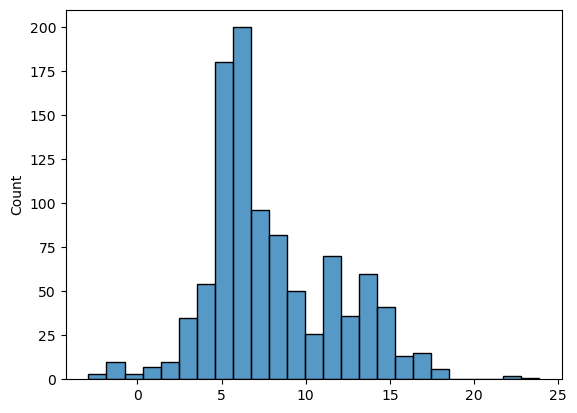

In [52]:
sns.histplot(x = np.array([ATEs[i][2] for i in range(1000)]))

<AxesSubplot:ylabel='Count'>

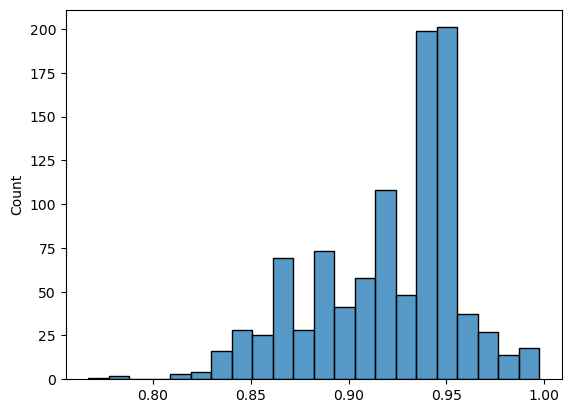

In [53]:
sns.histplot(x = np.array([ATEs[i][3] for i in range(1000)]))

Видно, что разница средних стала **еще меньше**: средняя выручка с исправлениями не выросла, и значимости все так же нет. Вывод: эксперемент нужно признать неуспешным все таки.
Все таки сплит система была сломана несильно, потому и после исправления результат несильно поменялся.

### 5. Регрессионный анализ влияния отдельных переменных

### Первый взгляд на построенние адекватной модели

Для того, чтобы оценить влияние отдельных факторов займемся регрессионным анализом.

Поменяем данные немного о начале и конце возрастного фильтра, чтобы они не зависили от возраста напрямую совсем. Понятно, что зависимость останется, и границы связанны с возрастом (40-летний/яя может поставить на 20 лет младше границу, а 20-летний/яя не может, на пример).

In [54]:
df_r = df.loc[:,['age', 'attraction_coeff', 'coins', 'gender', 'age_filter_start',
       'age_filter_end', 'views_count', 'was_premium', 'is_premium',
       'total_revenue', 'visit_days_max', 'active_weeks', 'n_visit_days',
       'is_europe', 'is_south_america', 'is_asia', 'is_oceania', 'is_africa',
       'is_argentina', 'is_france', 'is_italy', 'is_spain', 'is_chile',
       'is_united_arab_emirates', 'is_germany', 'is_united_kingdom',
       'is_canada', 'is_the_other', 'is_israel', 'is_portugal', 'is_belgium',
       'is_australia', 'treatment']]

Построим регрессию просто на __все__ переменные.

In [55]:
df_r['const'] = [1]*df.shape[0] # так по дефолту костанты нет
x1 = df_r.drop(['total_revenue'], axis = 1)
y = df_r['total_revenue']

In [56]:
model = sm.OLS(y, x1)
results1 = model.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     85.18
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:18:01   Log-Likelihood:            -1.2834e+05
No. Observations:               12912   AIC:                         2.568e+05
Df Residuals:                   12879   BIC:                         2.570e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                       

Большинство коеффициентов незначимы, а странновые так вообще все.
Так как странновые, скорее всего, связаны между ссобой (переменные континента и страны), проблема может быть связанна с мультиколлиарностью. Посмотри сколько потеряем объясненной дисперсии, если исключим эти переменные.

In [57]:
x = df_r.drop(['total_revenue','is_europe', 'is_south_america', 'is_asia', 'is_oceania', 'is_africa',
               'is_argentina', 'is_france', 'is_italy', 'is_spain', 'is_chile',
               'is_united_arab_emirates', 'is_germany', 'is_united_kingdom',
               'is_canada', 'is_the_other', 'is_israel', 'is_portugal', 'is_belgium','is_australia'], axis = 1)
y = df_r['total_revenue']
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     208.5
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:18:01   Log-Likelihood:            -1.2835e+05
No. Observations:               12912   AIC:                         2.567e+05
Df Residuals:                   12898   BIC:                         2.568e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -5.3313      4.890  

In [58]:
f_value = (results1.rsquared - results.rsquared)*(x1.shape[0] - x1.shape[1])/ \
            ((1 - results1.rsquared) * (x1.shape[1] - x.shape[1]))
fp_value = ss.f.cdf(f_value, x1.shape[1] - x.shape[1], x1.shape[0] - x1.shape[1])
print(f'Длинная регрессия лучше с вероятностью {round(fp_value*100, 3)} %')

Длинная регрессия лучше с вероятностью 32.363 %


Тест на длинную/короткую регрессию говорит, что короткая лучше (что немудрено, исправленный р-квадрат не изменился), можно с чистой совестью отбросить страновые переменные. Пока по крайней мере. 
Посмотрим есть ли гетероскедастичность. Проведем сначала тест Уайта на ее наличие.

### Проблемы с гетороскедастичностью и вопросы к спецификации модели

In [59]:
print(f'Гетероскедастичности нет с вер.оятностью {sm.stats.diagnostic.het_white(results.resid, x)[3]} %')

Гетероскедастичности нет с вер.оятностью 0.0 %


In [60]:
print(f'Распределение ошибок нормально с вероятностью {ss.normaltest(results.resid)[1]} %')

Распределение ошибок нормально с вероятностью 0.0 %


In [61]:
print(f'Зависит от линейного набора коэфициентов с вероятностью\
        {round(1-sm.stats.diagnostic.het_breuschpagan(results.resid, x)[3], 3)*100} %')

Зависит от линейного набора коэфициентов с вероятностью        100.0 %


То, что есть линейная зависимость между дисперсией и этим линейным набором переменных + низкий R-квадрат наводит на мысль, что дело скорее в спецификации модели, нежели в специфической версии гетероскедастичности. Посмотрим как эндогенная переменная засвисит от регрессоров:

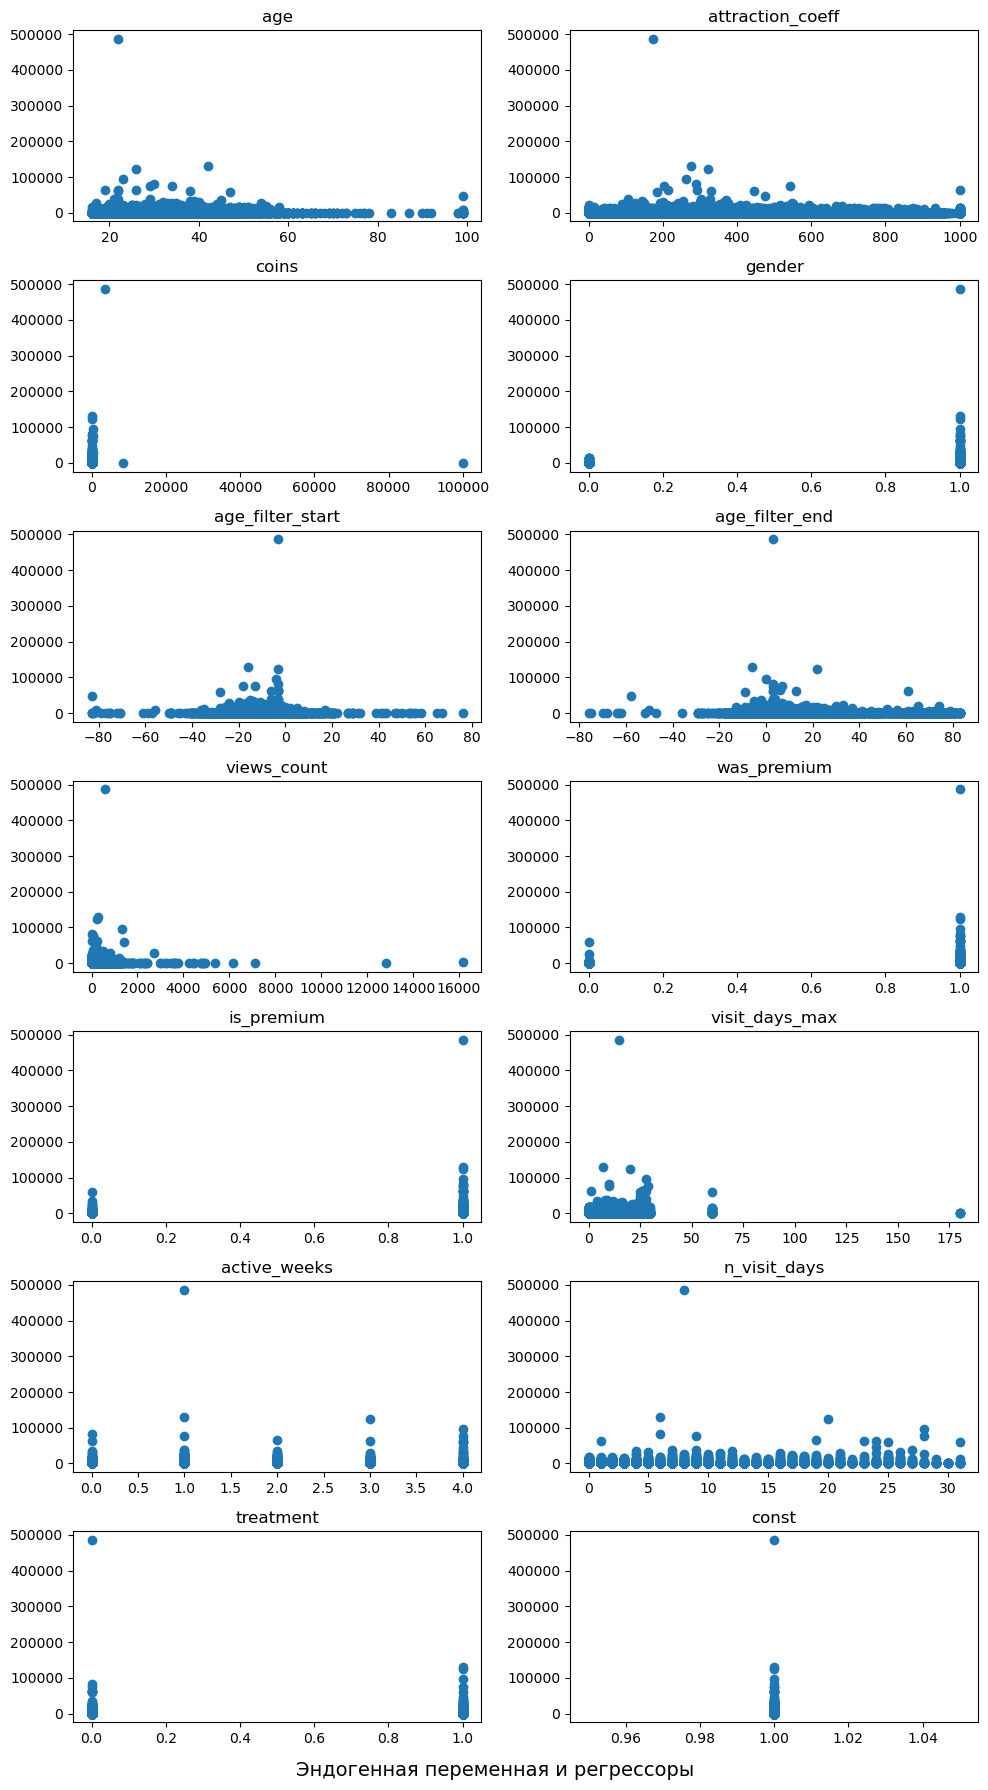

In [62]:
keys = []
for i in range(7):
    for j in range(2):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(7, 2, figsize=(10, 18))
  
for i in range(7):
    for j in range(2):
        inter = interat[str(i)+str(j)]
        axis[i, j].scatter(x[x.columns[inter]], y)
        axis[i, j].set_title(x.columns[inter])

figure.suptitle('Эндогенная переменная и регрессоры', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

Какой-то однозначной значной зависимости не видно. Однако можно заметить выбросы, часть из которых не кажется естественными.

### 6. Фильтрация

### Подозреваемые переменные и их распредление. Фильтрация и распределение после фильтрации

Предположим некторые волюнтаристские, но здравые критерии фильтрации данных, чтобы исключить выбросы.
1. Выручка больше нуля и меньше 100 тысяч
2. Возраст меньше 60
3. Возраста партнера нижняя и верхняя границы не должны отличаться на 20 лет


До фильтрации:

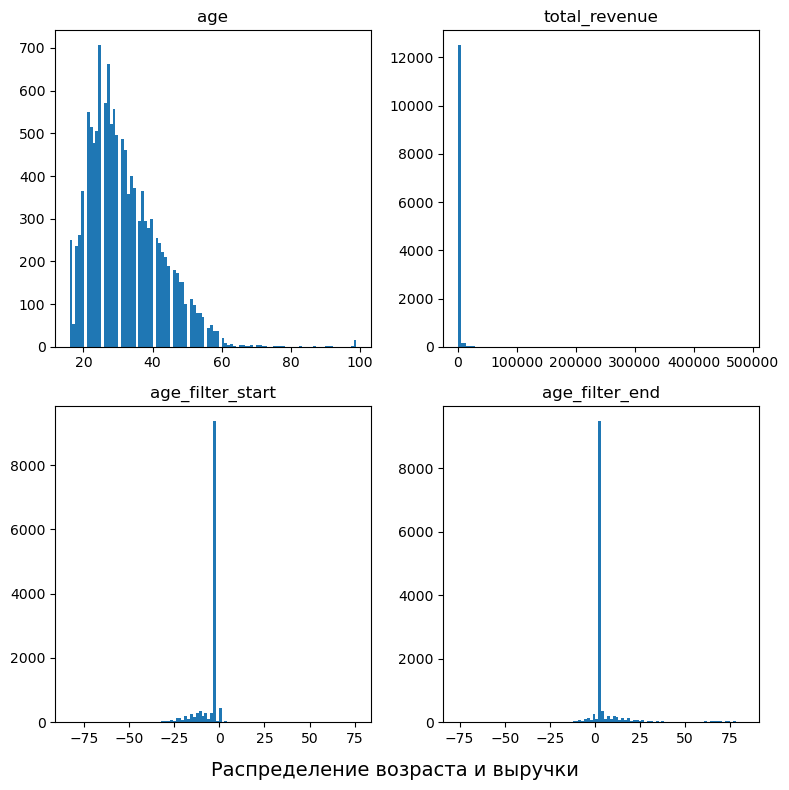

In [63]:
lst_of_filtration_columns = ['age', 'total_revenue', 'age_filter_start', 'age_filter_end']
interat = ['00', '01', '10', '11']
figure, axis = plt.subplots(2, 2, figsize=(8, 8))
  
for i in range(2):
    for j in range(2):
        x = interat.index(str(i)+str(j))
        axis[i, j].hist(df[lst_of_filtration_columns[x]], bins = 100)
        axis[i, j].set_title(lst_of_filtration_columns[x])

figure.suptitle('Распределение возраста и выручки', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

In [64]:
df_new = df.query('total_revenue >= 0 & total_revenue < 100000') \
            .query('age < 60') \
            .query('age_filter_start > -20 & age_filter_start < 20') \
            .query('age_filter_end > -20 & age_filter_end < 20')

После фильтрации:

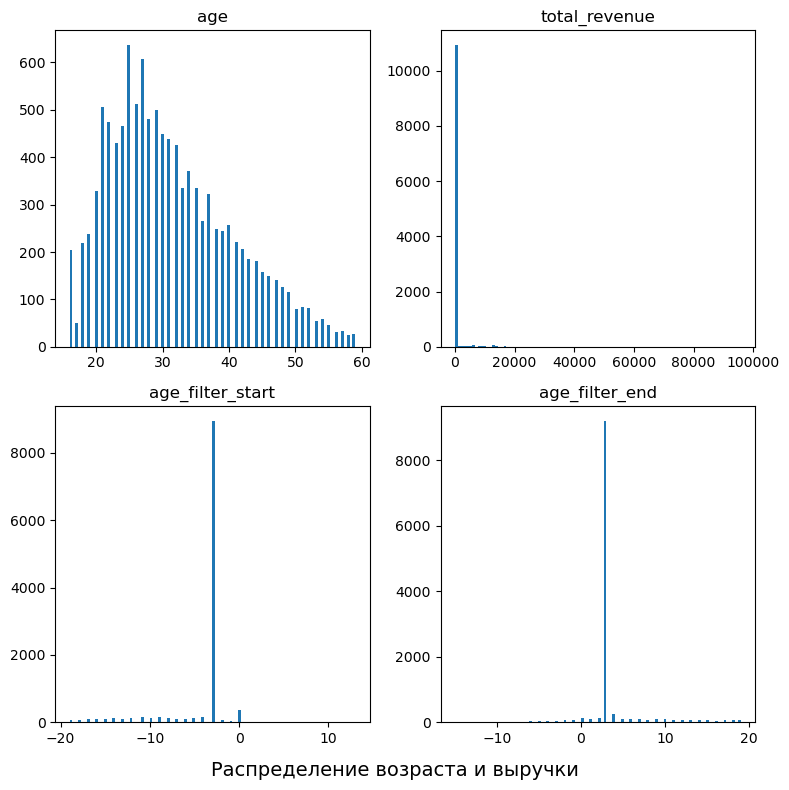

In [65]:
figure, axis = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        x = interat.index(str(i)+str(j))
        axis[i, j].hist(df_new[lst_of_filtration_columns[x]], bins = 100)
        axis[i, j].set_title(lst_of_filtration_columns[x])

figure.suptitle('Распределение возраста и выручки', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

Такие криттери позволяют, на мой взгляд, исключить слабо возможные в реальной жизни значения, не изменяя основного распределения характеристик.

### Проверка распределения всех характеристик после фильтрации

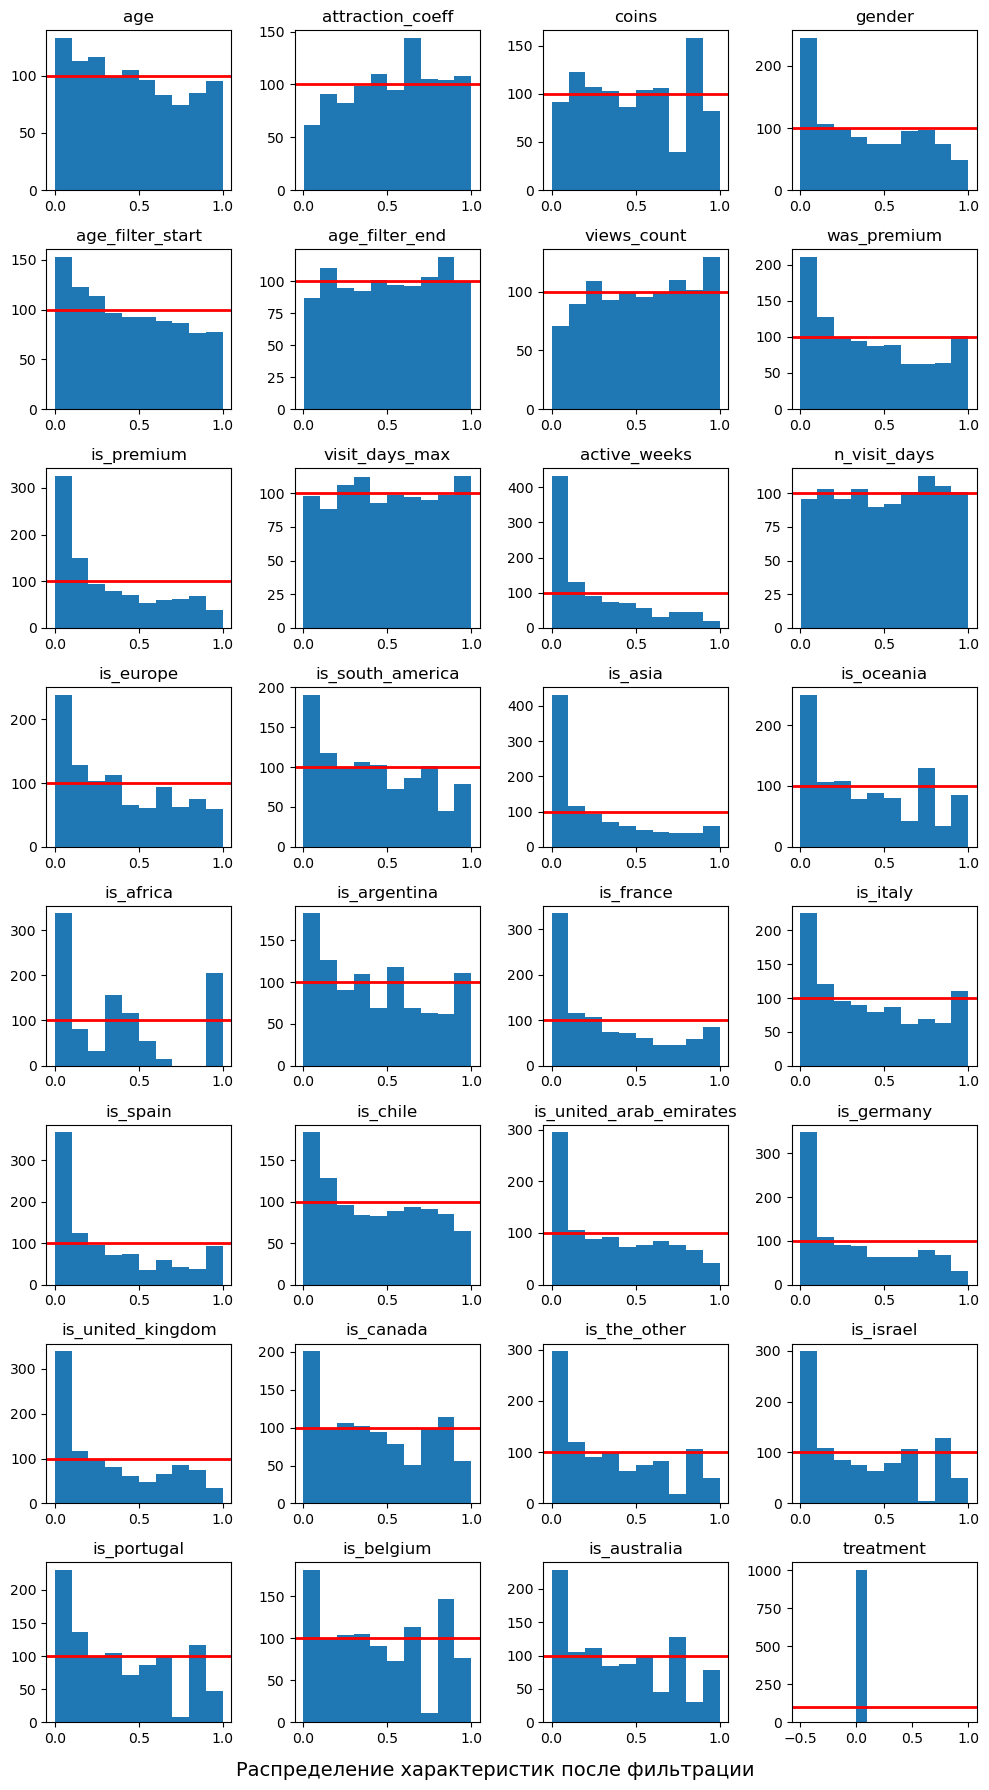

In [66]:
np.random.seed(4)
compare_table = a_a_boot(df_new.drop(['total_revenue', 'control_1', 'control_2'], axis = 1), 
                                      'treatment == 1', 'treatment == 0')

keys = []
for i in range(8):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(8, 4, figsize=(10, 18))
  
for i in range(8):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(compare_table[compare_table.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(compare_table.columns[x])

figure.suptitle('Распределение характеристик после фильтрации', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

In [67]:
FPR(compare_table).sort_values(ascending = False)

treatment                  1.000
propensity_score_c         0.366
is_asia                    0.338
is_africa                  0.322
active_weeks               0.319
is_united_kingdom          0.270
is_germany                 0.268
is_spain                   0.251
is_premium                 0.229
is_france                  0.226
is_the_other               0.224
is_israel                  0.212
is_united_arab_emirates    0.207
gender                     0.170
is_oceania                 0.165
is_portugal                0.154
is_australia               0.152
is_europe                  0.150
was_premium                0.135
is_italy                   0.135
is_canada                  0.124
is_chile                   0.123
is_south_america           0.121
is_argentina               0.107
propensity_score           0.107
is_belgium                 0.106
dist                       0.103
age_filter_start           0.084
groups                     0.084
age                        0.074
visit_days

Почти те же проблемы, что и были до фильтрации. Что хорошо на самом деле: я не исключил ничего такого, что повлияло было на распределение существенно.

### А/В тест после фильтрации

In [68]:
df_new['treatment'] = [0 if x == 1 else 1 for x in (df_new.control_1 + df_new.control_2).to_list()]
t = df_new.query('treatment == 1').total_revenue.to_numpy()
c = df_new.query('treatment == 0').total_revenue.to_numpy()
if ss.normaltest(t).pvalue > 0.05 or ss.normaltest(c).pvalue > 0.05:
    p_value = ss.mannwhitneyu(t, c).pvalue
else:
    p_value = ss.ttest_ind(t, c).pvalue
print(f'Средняя выручка в тестовой группе {round(np.mean(t))} со стандартным отклонением {round(np.std(t))},' + 
      f'{chr(10)}в контрольной группе {round(np.mean(c))} со стандартным отклонением {round(np.std(c))},'+ 
      f' {chr(10)}вероятность равенства средних {round(p_value)}')

Средняя выручка в тестовой группе 477 со стандартным отклонением 3456,
в контрольной группе 442 со стандартным отклонением 2857, 
вероятность равенства средних 1


Все еще нет недостаточно велика разница средних или недостаточно мала дисперсия между тестовой и контрольной группами.

Так как те же проблемы, что и до фильтрации, так же применим PSM

### Propensity score matching после фильтрации

In [69]:
X_not_uniform = df_new[not_uniform].to_numpy()
y = df_new.treatment.to_numpy()
model = LogisticRegression(class_weight='balanced', max_iter = 1000)
model = model.fit(X_not_uniform, y)
df_new['propensity_score'] = 1/(1+np.exp(-X_not_uniform.dot(model.coef_[0])))
X_not_uniform_c = df_new[not_uniform_c].to_numpy()
model = LogisticRegression(class_weight='balanced')
model = model.fit(X_not_uniform_c, y)
df_new['propensity_score_c'] = 1/(1+np.exp(-X_not_uniform_c.dot(model.coef_[0])))

<AxesSubplot:xlabel='propensity_score_c', ylabel='propensity_score'>

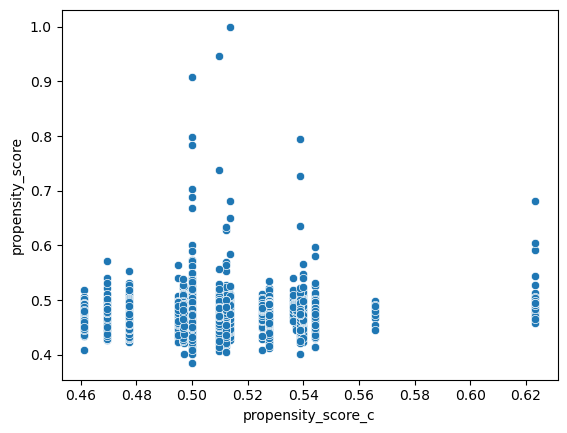

In [70]:
sns.scatterplot(data = df_new, x = 'propensity_score_c', y = 'propensity_score')

In [71]:
ATEs = []
for i in range(1000):
    try:
        ATEs.append(ATE(df_new, ['propensity_score_c', 'propensity_score'], 'treatment', i, 20))
    except:
        print(f'с {i} что-то пошло не так')
        break

Удалено 3 наблюдений при random state = 0
Удалено 3 наблюдений при random state = 1
Удалено 3 наблюдений при random state = 2
Удалено 3 наблюдений при random state = 3
Удалено 3 наблюдений при random state = 4
Удалено 3 наблюдений при random state = 5
Удалено 3 наблюдений при random state = 6
Удалено 3 наблюдений при random state = 7
Удалено 3 наблюдений при random state = 8
Удалено 3 наблюдений при random state = 9
Удалено 3 наблюдений при random state = 10
Удалено 3 наблюдений при random state = 11
Удалено 3 наблюдений при random state = 12
Удалено 3 наблюдений при random state = 13
Удалено 3 наблюдений при random state = 14
Удалено 3 наблюдений при random state = 15
Удалено 3 наблюдений при random state = 16
Удалено 3 наблюдений при random state = 17
Удалено 3 наблюдений при random state = 18
Удалено 3 наблюдений при random state = 19
Удалено 3 наблюдений при random state = 20
Удалено 3 наблюдений при random state = 21
Удалено 3 наблюдений при random state = 22
Удалено 3 наблюдений 

Удалено 3 наблюдений при random state = 189
Удалено 3 наблюдений при random state = 190
Удалено 3 наблюдений при random state = 191
Удалено 3 наблюдений при random state = 192
Удалено 3 наблюдений при random state = 193
Удалено 3 наблюдений при random state = 194
Удалено 3 наблюдений при random state = 195
Удалено 3 наблюдений при random state = 196
Удалено 3 наблюдений при random state = 197
Удалено 3 наблюдений при random state = 198
Удалено 3 наблюдений при random state = 199
Удалено 3 наблюдений при random state = 200
Удалено 3 наблюдений при random state = 201
Удалено 3 наблюдений при random state = 202
Удалено 3 наблюдений при random state = 203
Удалено 3 наблюдений при random state = 204
Удалено 3 наблюдений при random state = 205
Удалено 3 наблюдений при random state = 206
Удалено 3 наблюдений при random state = 207
Удалено 3 наблюдений при random state = 208
Удалено 3 наблюдений при random state = 209
Удалено 3 наблюдений при random state = 210
Удалено 3 наблюдений при random 

Удалено 3 наблюдений при random state = 376
Удалено 3 наблюдений при random state = 377
Удалено 3 наблюдений при random state = 378
Удалено 3 наблюдений при random state = 379
Удалено 3 наблюдений при random state = 380
Удалено 3 наблюдений при random state = 381
Удалено 3 наблюдений при random state = 382
Удалено 3 наблюдений при random state = 383
Удалено 3 наблюдений при random state = 384
Удалено 3 наблюдений при random state = 385
Удалено 3 наблюдений при random state = 386
Удалено 3 наблюдений при random state = 387
Удалено 3 наблюдений при random state = 388
Удалено 3 наблюдений при random state = 389
Удалено 3 наблюдений при random state = 390
Удалено 3 наблюдений при random state = 391
Удалено 3 наблюдений при random state = 392
Удалено 3 наблюдений при random state = 393
Удалено 3 наблюдений при random state = 394
Удалено 3 наблюдений при random state = 395
Удалено 3 наблюдений при random state = 396
Удалено 3 наблюдений при random state = 397
Удалено 3 наблюдений при random 

Удалено 3 наблюдений при random state = 563
Удалено 3 наблюдений при random state = 564
Удалено 3 наблюдений при random state = 565
Удалено 3 наблюдений при random state = 566
Удалено 3 наблюдений при random state = 567
Удалено 3 наблюдений при random state = 568
Удалено 3 наблюдений при random state = 569
Удалено 3 наблюдений при random state = 570
Удалено 3 наблюдений при random state = 571
Удалено 3 наблюдений при random state = 572
Удалено 3 наблюдений при random state = 573
Удалено 3 наблюдений при random state = 574
Удалено 3 наблюдений при random state = 575
Удалено 3 наблюдений при random state = 576
Удалено 3 наблюдений при random state = 577
Удалено 3 наблюдений при random state = 578
Удалено 3 наблюдений при random state = 579
Удалено 3 наблюдений при random state = 580
Удалено 3 наблюдений при random state = 581
Удалено 3 наблюдений при random state = 582
Удалено 3 наблюдений при random state = 583
Удалено 3 наблюдений при random state = 584
Удалено 3 наблюдений при random 

Удалено 3 наблюдений при random state = 750
Удалено 3 наблюдений при random state = 751
Удалено 3 наблюдений при random state = 752
Удалено 3 наблюдений при random state = 753
Удалено 3 наблюдений при random state = 754
Удалено 3 наблюдений при random state = 755
Удалено 3 наблюдений при random state = 756
Удалено 3 наблюдений при random state = 757
Удалено 3 наблюдений при random state = 758
Удалено 3 наблюдений при random state = 759
Удалено 3 наблюдений при random state = 760
Удалено 3 наблюдений при random state = 761
Удалено 3 наблюдений при random state = 762
Удалено 3 наблюдений при random state = 763
Удалено 3 наблюдений при random state = 764
Удалено 3 наблюдений при random state = 765
Удалено 3 наблюдений при random state = 766
Удалено 3 наблюдений при random state = 767
Удалено 3 наблюдений при random state = 768
Удалено 3 наблюдений при random state = 769
Удалено 3 наблюдений при random state = 770
Удалено 3 наблюдений при random state = 771
Удалено 3 наблюдений при random 

Удалено 3 наблюдений при random state = 937
Удалено 3 наблюдений при random state = 938
Удалено 3 наблюдений при random state = 939
Удалено 3 наблюдений при random state = 940
Удалено 3 наблюдений при random state = 941
Удалено 3 наблюдений при random state = 942
Удалено 3 наблюдений при random state = 943
Удалено 3 наблюдений при random state = 944
Удалено 3 наблюдений при random state = 945
Удалено 3 наблюдений при random state = 946
Удалено 3 наблюдений при random state = 947
Удалено 3 наблюдений при random state = 948
Удалено 3 наблюдений при random state = 949
Удалено 3 наблюдений при random state = 950
Удалено 3 наблюдений при random state = 951
Удалено 3 наблюдений при random state = 952
Удалено 3 наблюдений при random state = 953
Удалено 3 наблюдений при random state = 954
Удалено 3 наблюдений при random state = 955
Удалено 3 наблюдений при random state = 956
Удалено 3 наблюдений при random state = 957
Удалено 3 наблюдений при random state = 958
Удалено 3 наблюдений при random 

<AxesSubplot:ylabel='Count'>

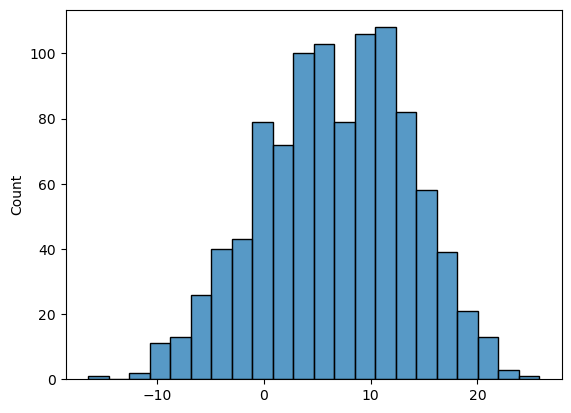

In [72]:
sns.histplot(x = np.array([ATEs[i][2] for i in range(1000)]))

<AxesSubplot:ylabel='Count'>

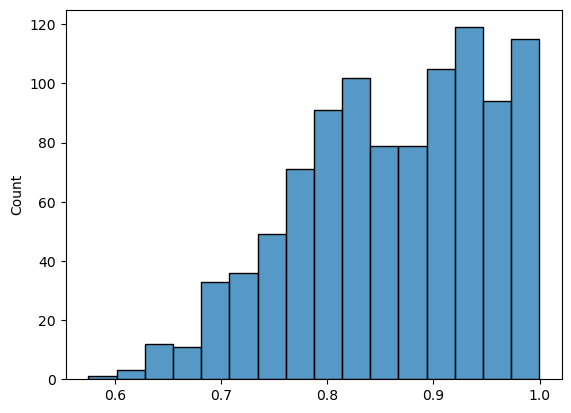

In [73]:
sns.histplot(x = np.array([ATEs[i][3] for i in range(1000)]))

Новое распределение после фильтрации показывает, что разница между двумя группами стала еще меньше. Значимой разницы средних между контрольной и тестовой группой нет.

### 7. Регрессионный анализ влияния отдельных переменных после фильтрации

### Длинная / короткая регресия

Сначала со всеми переменными.

In [74]:
df_r = df_new
df_r['const'] = [1]*df_new.shape[0] # так как по дефолту костанты нет
x_l = df_r.drop(['total_revenue', 'propensity_score', 'propensity_score_c', 'groups', 'dist', 
               'control_1', 'control_2'], axis = 1)
y = df_r['total_revenue']
model = sm.OLS(y, x_l)
results_l = model.fit()
print(results_l.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     281.2
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:47:29   Log-Likelihood:            -1.0398e+05
No. Observations:               11348   AIC:                         2.080e+05
Df Residuals:                   11316   BIC:                         2.083e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                       

Заметно вырос р-квадрат, но в целом проблемы те же, что и были до фильтрации.

In [75]:
print(f'Гетероскедастичности нет с вероятностью {sm.stats.diagnostic.het_white(results_l.resid, x_l)[3]} %')

Гетероскедастичности нет с вероятностью 0.0 %


In [76]:
sm.stats.diagnostic.het_breuschpagan(results_l.resid, x_l.loc[:, ['attraction_coeff', 'age']])[3]

2.8033103769674474e-05

In [77]:
print(f'Распределение ошибок нормально с вероятностью {ss.normaltest(results.resid)[1]} %')

Распределение ошибок нормально с вероятностью 0.0 %


Прежде чем бороться с гетероскедастичностью посмотрим можно ли как-то внятно улучшить спецификацию модели.

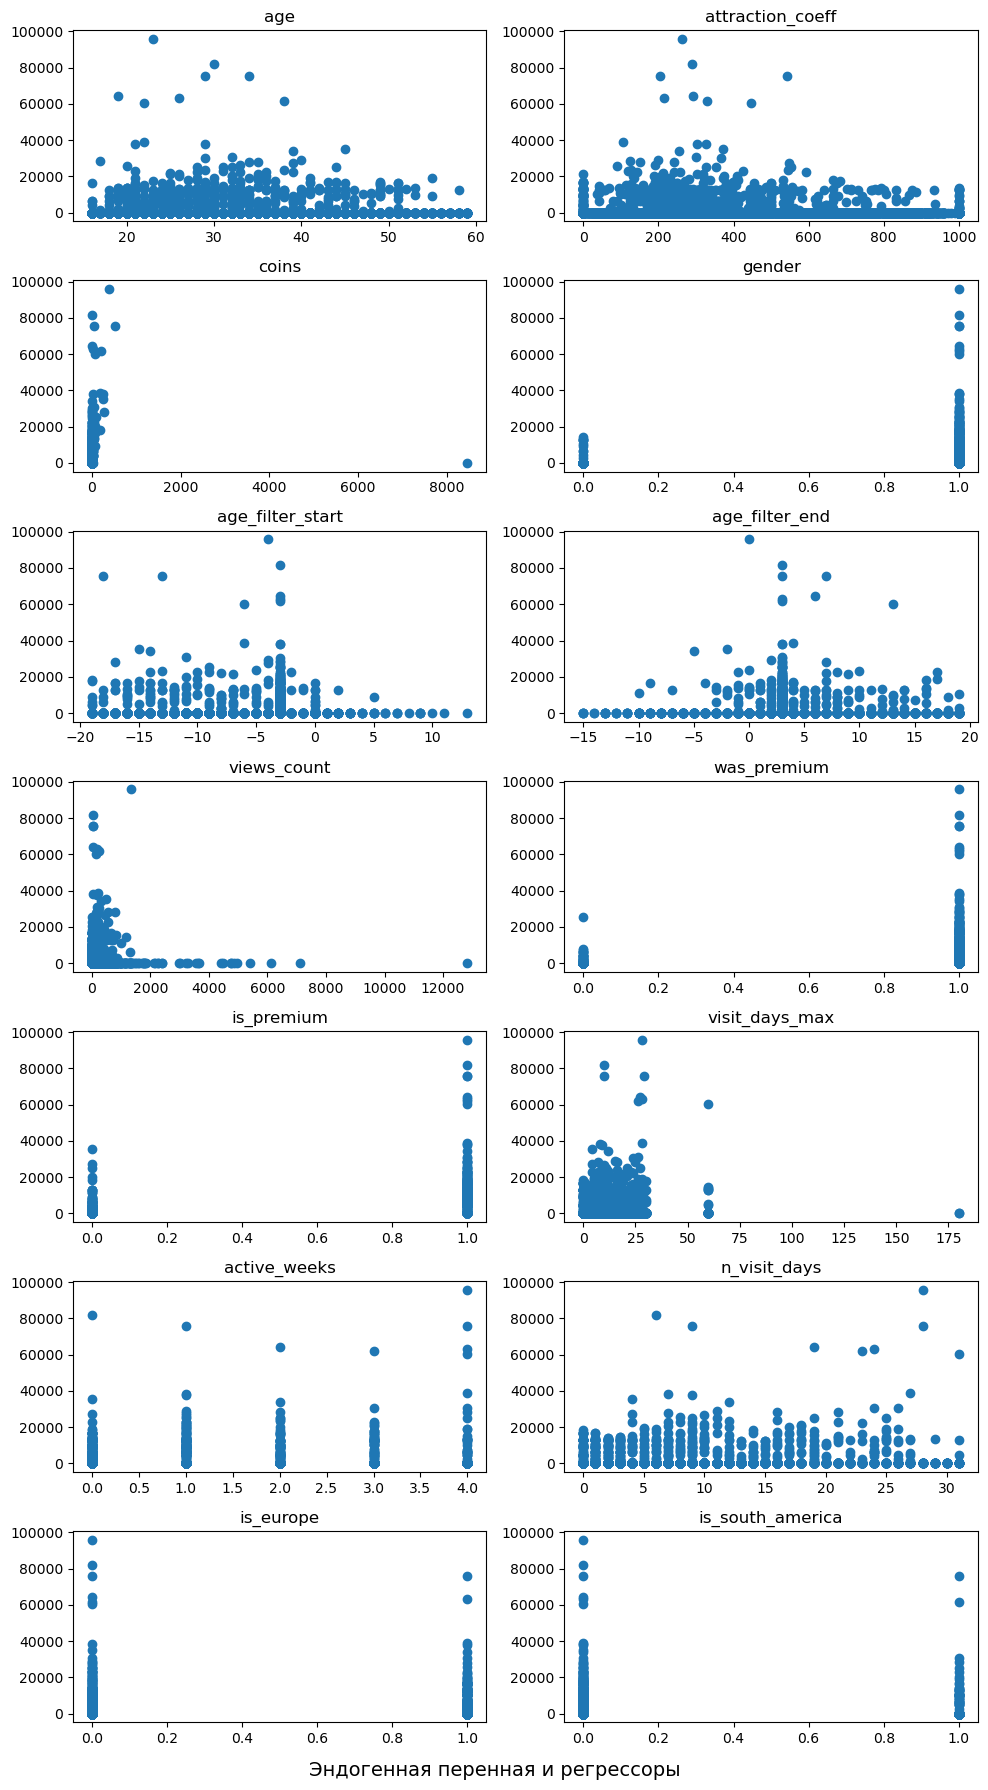

In [78]:
keys = []
for i in range(7):
    for j in range(2):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(7, 2, figsize=(10, 18))
  
for i in range(7):
    for j in range(2):
        inter = interat[str(i)+str(j)]
        axis[i, j].scatter(x_l[x_l.columns[inter]], y)
        axis[i, j].set_title(x_l.columns[inter])

figure.suptitle('Эндогенная перенная и регрессоры', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

Не вижу никакой более менее подходящей функциональной зависимости любой из переменных и выручкой. Можно в теории еще больше уменьшить вариацию выручки взяв ее логарифм.

Проверим как и на прошлом этапе нужность страновых переменных.

In [79]:
x_s = df_r.drop(['total_revenue', 'propensity_score', 'propensity_score_c', 'groups', 'dist', 
               'control_1', 'control_2', 'is_argentina', 'is_france',
               'is_europe', 'is_south_america',
               'is_asia', 'is_oceania', 'is_africa',
               'is_italy', 'is_spain', 'is_chile', 'is_united_arab_emirates',
               'is_germany', 'is_united_kingdom', 'is_canada', 'is_the_other',
               'is_israel', 'is_portugal', 'is_belgium', 'is_australia'], axis = 1)
model = sm.OLS(y, x_s)
results_s = model.fit()
print(results_s.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     669.8
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:47:33   Log-Likelihood:            -1.0399e+05
No. Observations:               11348   AIC:                         2.080e+05
Df Residuals:                   11334   BIC:                         2.081e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -2.1252      2.459  

In [80]:
f_value = (results_l.rsquared - results_s.rsquared)*(x_l.shape[0] - x_l.shape[1])/ \
            ((1 - results_l.rsquared) * (x_l.shape[1] - x_s.shape[1]))
fp_value = ss.f.cdf(f_value, x_l.shape[1] - x_s.shape[1], x_l.shape[0] - x_l.shape[1])
print(f'Длинная регрессия лучше с вероятностью {round(fp_value*100, 3)} %')
x = x_s

Длинная регрессия лучше с вероятностью 18.404 %


Снова длинная регрессия не дает значимого прироста в доли объясняющей дисперсии, потому выбираем короткую.

### Гетероскедастичность и устойчивые к гетероскедастичности ошибки

Проверим на наличие гетероскедастичности

In [81]:
print(f'Гетероскедастичности нет с вероятностью {sm.stats.diagnostic.het_white(results_s.resid, x_s)[3]} %')

Гетероскедастичности нет с вероятностью 0.0 %


Гетероскедастичность есть, построим регрессию на ошибки

In [82]:
e_2 = results_s.resid ** 2
model = sm.OLS(e_2, x_s)
results_errors = model.fit()
print(results_errors.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     47.05
Date:                Tue, 17 Jan 2023   Prob (F-statistic):          5.54e-119
Time:                        00:47:33   Log-Likelihood:            -2.2633e+05
No. Observations:               11348   AIC:                         4.527e+05
Df Residuals:                   11334   BIC:                         4.528e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age              -1.984e+05   1.18e+05  

Уравнение получилось значимым, а значит есть зависимость между таким набором переменных и ошибками.

In [83]:
print(f'Зависит от линейного набора коэфициентов с вероятностью\
        {(1 - sm.stats.diagnostic.het_breuschpagan(results_s.resid, x_s)[3]) * 100} %')

Зависит от линейного набора коэфициентов с вероятностью        100.0 %


Вероятно, взвешенный МНК помог бы, но не все переменные можно "взвесить" и не получить другую качественную переменную: обратите внимание на переменную is_premium, от нее значимо зависят ошибки, но ее нельзя взесить, так как она фиктивная. Если к ней применить веса, то она перестанет принимать только 2 значения, и интерпретировать ее станет невозможно.

Потому просто возьмем устойчивые к гетероскедастичности стандартные ошибки для коэфициентов. В нашем случае обычные HC0, так как у нас большая выборка.

In [84]:
model = sm.OLS(y, x_s)
results = model.fit()
HC0 = np.diagonal(np.dot(np.linalg.inv(np.dot(x_s.T, x_s)), 
       np.dot(np.dot(np.dot(x_s.T, np.diag(results.resid ** 2)), x_s), 
              np.linalg.inv(np.dot(x_s.T, x_s)))))
results.bse.loc[:] = np.sqrt(HC0)
results.tvalues = results.params / np.sqrt(HC0)
results.pvalues.loc[:] = ss.norm.pdf(results.params / np.sqrt(HC0))
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     669.8
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:47:34   Log-Likelihood:            -1.0399e+05
No. Observations:               11348   AIC:                         2.080e+05
Df Residuals:                   11334   BIC:                         2.081e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -2.1252      2.089  

Теперь посмотрим как значимые переменные влияют на выручку при увеличении подписки (в случае отнесения в группу тритмента)

In [85]:
x = df_r.drop(['total_revenue', 'propensity_score', 'propensity_score_c', 'groups', 'dist', 
               'control_1', 'control_2', 'is_argentina', 'is_france',
               'is_europe', 'is_south_america',
               'is_asia', 'is_oceania', 'is_africa',
               'is_italy', 'is_spain', 'is_chile', 'is_united_arab_emirates',
               'is_germany', 'is_united_kingdom', 'is_canada', 'is_the_other',
               'is_israel', 'is_portugal', 'is_belgium', 'is_australia'], axis = 1)
y = df_r['total_revenue']
x['att_t'] = x.attraction_coeff * x.treatment
x['n_days_t'] = x.n_visit_days * x.treatment
model = sm.OLS(y, x)
results = model.fit()
HC0 = np.diagonal(np.dot(np.linalg.inv(np.dot(x.T, x)), 
       np.dot(np.dot(np.dot(x.T, np.diag(results.resid ** 2)), x), 
              np.linalg.inv(np.dot(x.T, x)))))
results.bse.loc[:] = np.sqrt(HC0)
results.tvalues = results.params / np.sqrt(HC0)
results.pvalues.loc[:] = ss.norm.pdf(results.params / np.sqrt(HC0))
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     581.0
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:47:34   Log-Likelihood:            -1.0399e+05
No. Observations:               11348   AIC:                         2.080e+05
Df Residuals:                   11332   BIC:                         2.081e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -2.1735      2.096  

Дополнительные переменные влияния тритмента не значимы, а значит нет дополнительного влияния на выручку у значимых переменных. Отдельно надо обратить внимание, что в такой конфигурации не значима переменная treatment ни в одной из вариаций, что говорит о том, что влияния изменения подписки нет. Так бывает, когда слишком пошожи между ссобой перемнные, что по отдельности они не значимы, а вместе эффект значим.

### Логирифмирование выручки и проверка Бокса-Кокса. Формирование окончательной модели

Проверим теперь, а стоит ли брать логарифм зависимой переменной. Для этого воспользуемся сравнением Бокса-Кокса:

In [86]:
Box_Cox_comparison(y, x_s)

К зависимой переменной добавили ее минимальное значение (0) по модулю + 1
С логарифмом лучше, так как SEE меньше: SEE = 1.0345440892380948, а без логарифма SEE = 2631920.0137837795


Ну раз лучше, значит так и сделаем:

In [87]:
x = df_r.drop(['total_revenue', 'propensity_score', 'propensity_score_c', 'groups', 'dist', 
               'control_1', 'control_2', 'is_argentina', 'is_france',
               'is_europe', 'is_south_america',
               'is_asia', 'is_oceania', 'is_africa',
               'is_italy', 'is_spain', 'is_chile', 'is_united_arab_emirates',
               'is_germany', 'is_united_kingdom', 'is_canada', 'is_the_other',
               'is_israel', 'is_portugal', 'is_belgium', 'is_australia'], axis = 1)
y = np.log(df_r['total_revenue']+1)
model = sm.OLS(y, x)
results = model.fit()
HC0 = np.diagonal(np.dot(np.linalg.inv(np.dot(x.T, x)), 
       np.dot(np.dot(np.dot(x.T, np.diag(results.resid ** 2)), x), 
              np.linalg.inv(np.dot(x.T, x)))))
results.bse.loc[:] = np.sqrt(HC0)
results.tvalues = results.params / np.sqrt(HC0)
results.pvalues.loc[:] = ss.norm.pdf(results.params / np.sqrt(HC0))
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1754.
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:47:35   Log-Likelihood:                -16288.
No. Observations:               11348   AIC:                         3.260e+04
Df Residuals:                   11334   BIC:                         3.271e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.0002      0.001  

Значимы привлекательность, монеты, пол, количество просмотров и количество дней. Посмотрим значимы ли они с переменной тритмента:

In [88]:
x = df_r.drop(['total_revenue', 'propensity_score', 'propensity_score_c', 'groups', 'dist', 
               'control_1', 'control_2', 'is_argentina', 'is_france',
               'is_europe', 'is_south_america',
               'is_asia', 'is_oceania', 'is_africa',
               'is_italy', 'is_spain', 'is_chile', 'is_united_arab_emirates',
               'is_germany', 'is_united_kingdom', 'is_canada', 'is_the_other',
               'is_israel', 'is_portugal', 'is_belgium', 'is_australia'], axis = 1)
x['attract_t'] = x['attraction_coeff'] * x['treatment']
x['n_days_t'] = x['n_visit_days'] * x['treatment']
x['views_t'] = x['views_count'] * x['treatment']
x['gender_t'] = x['gender'] * x['treatment']
y = np.log(df_r['total_revenue']+1)
model = sm.OLS(y, x)
results = model.fit()
HC0 = np.diagonal(np.dot(np.linalg.inv(np.dot(x.T, x)), 
       np.dot(np.dot(np.dot(x.T, np.diag(results.resid ** 2)), x), 
              np.linalg.inv(np.dot(x.T, x)))))
results.bse.loc[:] = np.sqrt(HC0)
results.tvalues = results.params / np.sqrt(HC0)
results.pvalues.loc[:] = ss.norm.pdf(results.params / np.sqrt(HC0))
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1343.
Date:                Tue, 17 Jan 2023   Prob (F-statistic):               0.00
Time:                        00:47:35   Log-Likelihood:                -16283.
No. Observations:               11348   AIC:                         3.260e+04
Df Residuals:                   11330   BIC:                         3.273e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.0001      0.001  

Вот на этой конфигурации остановимся. В этой конфигурации (с логарифмом зависимой переменной) нет разницы для переменной treatment: она не значима в обоих случаях



### 8 . Данные о транзакциях

### Какие именно транзакции в таблице. Таблица средних.

Посмотрим есть ли проблемы с тем набором наблюдений, что у нас есть:

In [89]:
uid = uid_test + uid_control_1 + uid_control_2
uid = sum([0 if i in uid else 1 for i in uid_test_t + uid_control_1_t + uid_control_2_t])
print(f'Вот такое количество пользователей есть в данных о транзакциях и нет в основных данных: {uid}')

Вот такое количество пользователей есть в данных о транзакциях и нет в основных данных: 0


In [90]:
n0 = df_t.shape[0]
n2 = df.query('is_premium == 1 | was_premium == 1').shape[0]
n1 = df_t.query('is_premium == 1 | was_premium == 1').shape[0]
print(f'В датасете с транзакциями ({n0}) меньше строк, чем премиум подписок было ({n2}) в основном датасете. {chr(10)}\
При этом не все данные о транзакциях свидетельствуют о покупке подписки ({n1} из {n0}), так как существуют транзакции \
с без данных о подписке,\
и, формально, мы не знаем сколько их и что это за данные.')

В датасете с транзакциями (978) меньше строк, чем премиум подписок было (1255) в основном датасете. 
При этом не все данные о транзакциях свидетельствуют о покупке подписки (926 из 978), так как существуют транзакции с без данных о подписке,и, формально, мы не знаем сколько их и что это за данные.


Данные о транзакция скорее всего такие: это некоторый срез данных с некоторыми транзакциями, которые не факт, что связаны с оформлением подписки. Нет, наверное, смысла анализировать динамику по дням в этом случае, так как нельзя будет отделить любое выброс от смещенности среза на определенный день. Чуть иначе с данными о том, какой способ привлечения (from_page) каких клиентов привлекает. Зная уже, какие переменные влияют на привлечение клиентов, посмотрим как они связанны с каналами привлечения.

In [91]:
df_t.groupby('from_page', as_index = False).agg({'total_revenue':'mean', 'is_none':'count',
                                                 'gender':'mean', 'n_visit_days':'mean',
                                                'attraction_coeff':'mean', 'views_count':'mean'}). \
        sort_values(by = 'total_revenue', ascending = False). \
        rename(columns = {'is_none': 'quantity'}).reset_index(drop = True).round(2)

,from_page,total_revenue,quantity,gender,n_visit_days,attraction_coeff,views_count
0,gifts,133333.20,20,1.00,8.95,276.70,264.10
1,menu,119700.21,72,1.00,14.64,308.12,408.53
2,the_other_page,67431.18,71,1.00,11.17,264.92,385.52
3,autorefill,28993.25,48,1.00,15.31,288.35,324.94
4,popular_users_chat,25452.27,15,1.00,15.67,316.73,130.13
5,empty_likes,20260.60,272,1.00,13.08,300.04,302.64
6,left_sidebar_menu,17044.11,47,0.96,11.81,334.85,181.74
7,autoreply_message,14488.34,80,1.00,8.32,397.05,81.36
8,promo_09,13960.51,61,1.00,14.13,335.79,141.98
9,trial_vip_popup,13044.41,149,0.95,7.18,331.19,77.71


### Таблицы значимости разницы между различными каналами привлечения.

In [92]:
import warnings
warnings.filterwarnings('ignore') 
# единственный раз скрываю ворнинги, так как не могу пофиксить их
# scipy почему-то говорит, что для теста kurtosistest only valid for n>=20, а я этот тест не использую даже, а
# в тесте Манна_Уитни таких ограничений нет.


from_page = df_t.from_page.unique().tolist()
lst_columns = ['total_revenue', 'gender', 'n_visit_days', 'attraction_coeff', 'views_count']
len_fp = len(from_page)
for j in lst_columns:
    exec(f'ct_{j} = np.array([0]*{len_fp}*{len_fp}).reshape(({len_fp}, {len_fp}))')
    exec(f'np.fill_diagonal(ct_{j}, [1]*{len_fp})')
    exec(f'ct_{j} = pd.DataFrame(ct_{j})')
    exec(f'ct_{j}.index = from_page')
    exec(f'ct_{j}.columns = from_page')
    temp_lst = from_page.copy()
    for i in from_page:
        temp_lst = [x for x in temp_lst if x != i]
        v0 = df_t.query(f'from_page == "{i}"')[j].to_numpy()
        for k in temp_lst:
            v1 = df_t.query(f'from_page == "{k}"')[j].to_numpy()
            if np.unique(v0).shape[0] > 5 or np.unique(v1).shape[0] > 5:
                if ss.normaltest(v0).pvalue < 0.05 or ss.normaltest(v1).pvalue < 0.05:
                    pv = ss.mannwhitneyu(v0, v1).pvalue
                else:       
                    pv = ss.ttest_ind(v0, v1).pvalue
                exec(f'ct_{j}.loc["{k}","{i}"] = pv')

            else:
                if (np.unique(v1) == np.unique(v0)).all():
                    
                    obs = [v0[v0 == i].shape[0] for i in np.unique(v0)]
                    exp = [v1[v1 == i].shape[0] for i in np.unique(v1)]
                    exp = [i*v0.shape[0]/v1.shape[0] for i in exp]
                    pv = ss.chisquare(obs, exp).pvalue
                    if (pv > 0 or pv >= 0) == False:
                        pv = 1
                    exec(f'ct_{j}.loc["{k}","{i}"] = pv')
                    
                else:
                    pv = 0
                    exec(f'ct_{j}.loc["{k}","{i}"] = pv')           

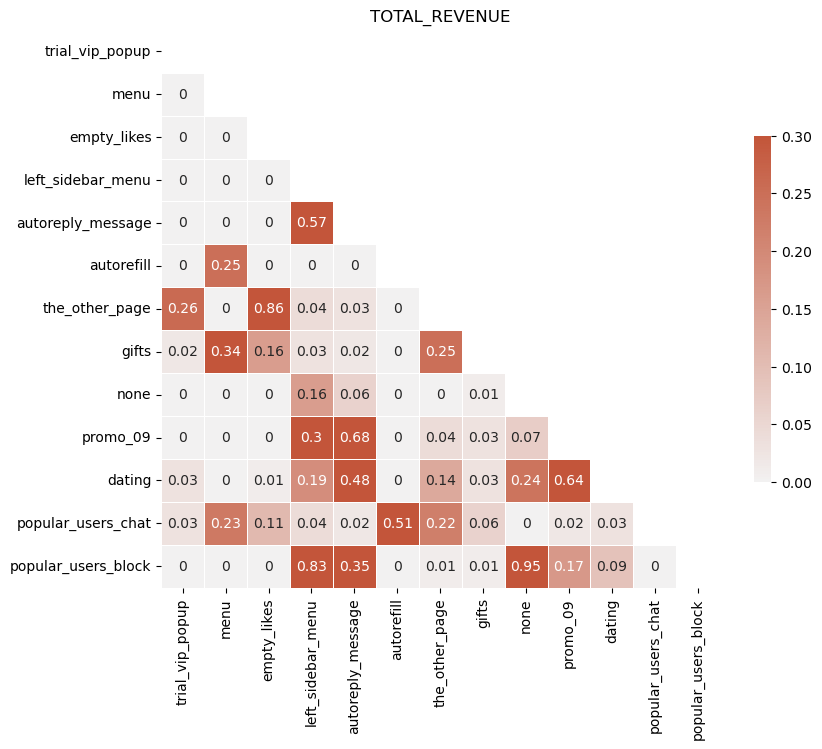

In [93]:
exec(f'corr = ct_{lst_columns[0]}.round(2)')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) \
            .set(title = lst_columns[0].upper())

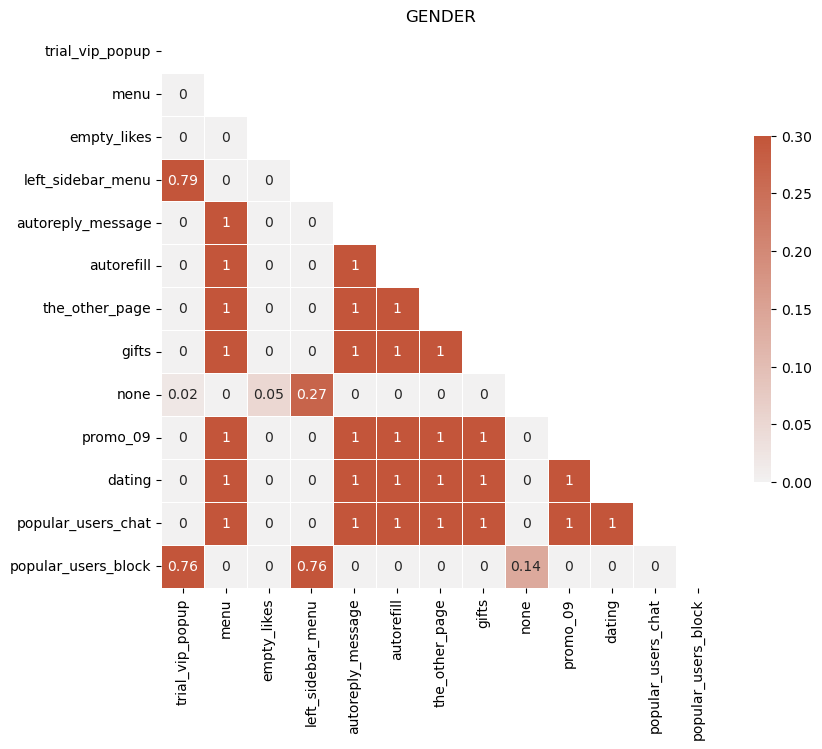

In [94]:
exec(f'corr = ct_{lst_columns[1]}.round(2)')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) \
            .set(title = lst_columns[1].upper())

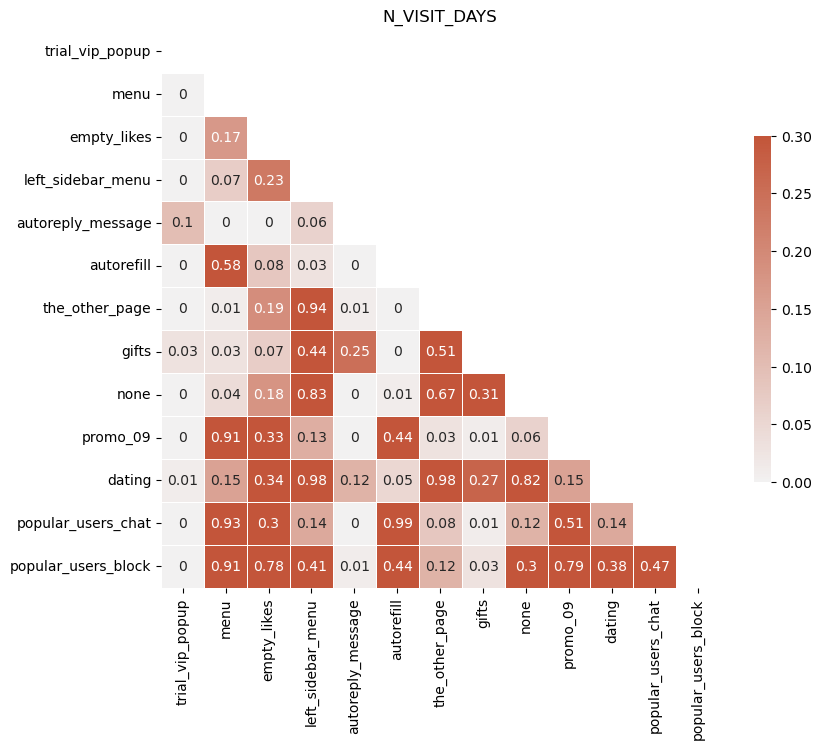

In [95]:
exec(f'corr = ct_{lst_columns[2]}.round(2)')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) \
            .set(title = lst_columns[2].upper())

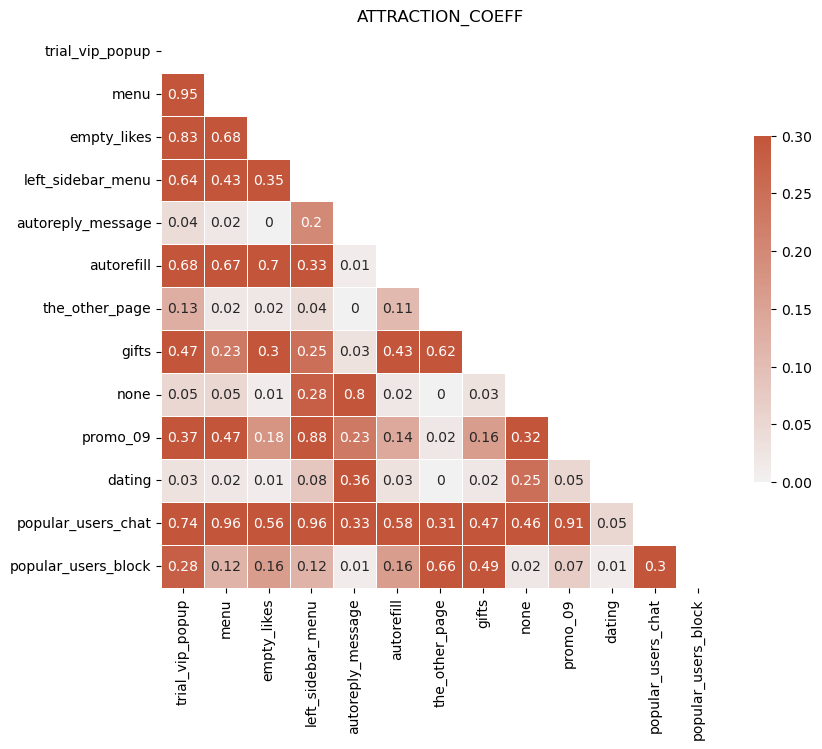

In [96]:
exec(f'corr = ct_{lst_columns[3]}.round(2)')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) \
            .set(title = lst_columns[3].upper())

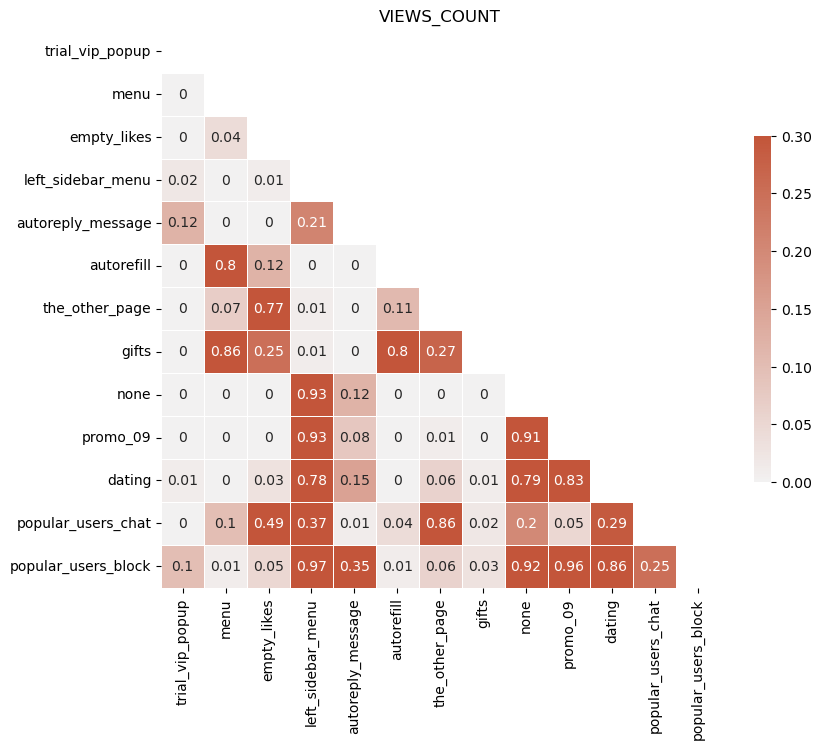

In [97]:
exec(f'corr = ct_{lst_columns[4]}.round(2)')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) \
            .set(title = lst_columns[4].upper())

================================================================================================================================

### Общие выводы
1. Увеличение подписки не произвело значимого увеличения выручки.
2. Ни одни из страновых переменных не оказались значимыми 
3. Значимыми оказались переменные: __привлекательности__, __пола__, __количества просмотров__, __наличие подписки__, __продолжительность пользования__, __количество дней__ и __количество просмотров при увеличении подписки__. При прочих равных:
            - При увеличении привлекательности на 10 уменьшает выручку на -0,6%
            - Мужчины (скорее всего, они обозначены за единицу) на 9,7% тратят больше
            - 100 просмотров увеличивают выручку на 2%
            - Наличие подписки в прошлом увеличивает выручку на 68%
            - Пользователи с подпиской тратят на 657% больше
            - Дополнительный день пользования приложением приносит 2,2% выручки
            - При увеличении подписки 100 дополнительных просмотров уменьшают выручку на 1%
4. Больше всего выручки принес канал оформления подписки "gifts": при том, что пользователи из этого канала по характеристикам не должны приносить много выручки. Вторым каналом привлечения является "menu", пользователи из этой группы не значимо отличаются от пользователей, которым подписку подарили, кроме продолжительностью пользования приложения. Третим каналом привлечения подписчиков -- это чат с популярными пользователями. У таких пользователей значимо меньше просмотров чем у пользователей из других групп. Остальные каналы привлечения привлекают еще меньше. Интересно, что мало приносит подписка, предложенная во время мэтча (dating). Видимо, пользователям, она не очень нужна, если подходящие мэтчи есть.

Вывод по существу: выручка зависит от переменных вовлеченности пользователей, чем больше вовлеченность, тем больше выручка. Скорее всего есть дополнительные плюшки помимо подписки, которые продаются в приложении, это же и объясняет, почему выручка на пользователя не кластаризируется вокруг некоторых значений. 

При этом увеличение стоимости подписки не привело к увеличению выручки, а по косвенным признакам, стоимость подписки уменьшила вовлеченность в пользование приложением (значимое и незначимое, но близкое к значимому, уменьшение количества просмотров и продолжительности пользования приложения), что хуже для выручке, чем увеличение стоимости. Жаль нет больше данных о тех, кто как пользуется при подаренной подписке. Если пользователи становятся более вовлеченными, то лучше будет снизить цену подписку, дабы повысить вовлеченность пользователей. Дальнейшее изучение я бы проводил в этом направлении.